Решение команды Team Buns

#### Устройство решения
Все решение разбито на несколько классов, каждый из которых представляет отдельный этап разработки. Класс Solution является высокоуровневой оболочкой этих классов, который содержит гиперпараметры, позволяющие гибко и быстро настраивать решение.

#### Предобработка данных и создание фичей.

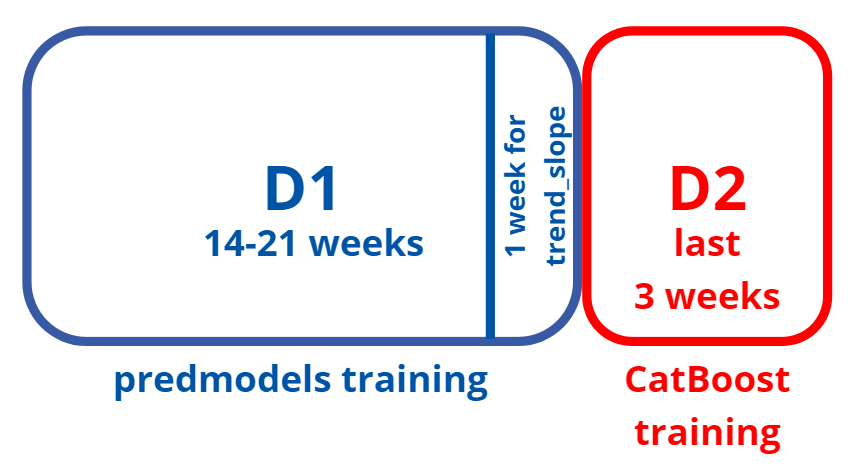

*d1* - датасет с данными не за последние *n_weeks_for_catboost* недель(для обучения предмоделей)\
*d2* - датасет с данными за последние *n_weeks_for_catboost* недель, (для обучения catboost)

На этапе создания признаков мы создаем целевые значения для обучения модели и дополнительные признаки на основе исторических данных и разбиваем исходный датасет на три части(при тестировании гипотез и локальной проверки и решения). Среди признаков следует выделить следующие: 
1. Угол наклона линии тренда(по каждому из дней недели)
2. Признаки на основе длительности просмотров(90 персентиль, среднее арифметическое, сумма)

Мы делаем упор на учет трендов и сезонности, что позволяет нашему решению минимизировать проблему нехватки исторических данных.

#### Моделирование 

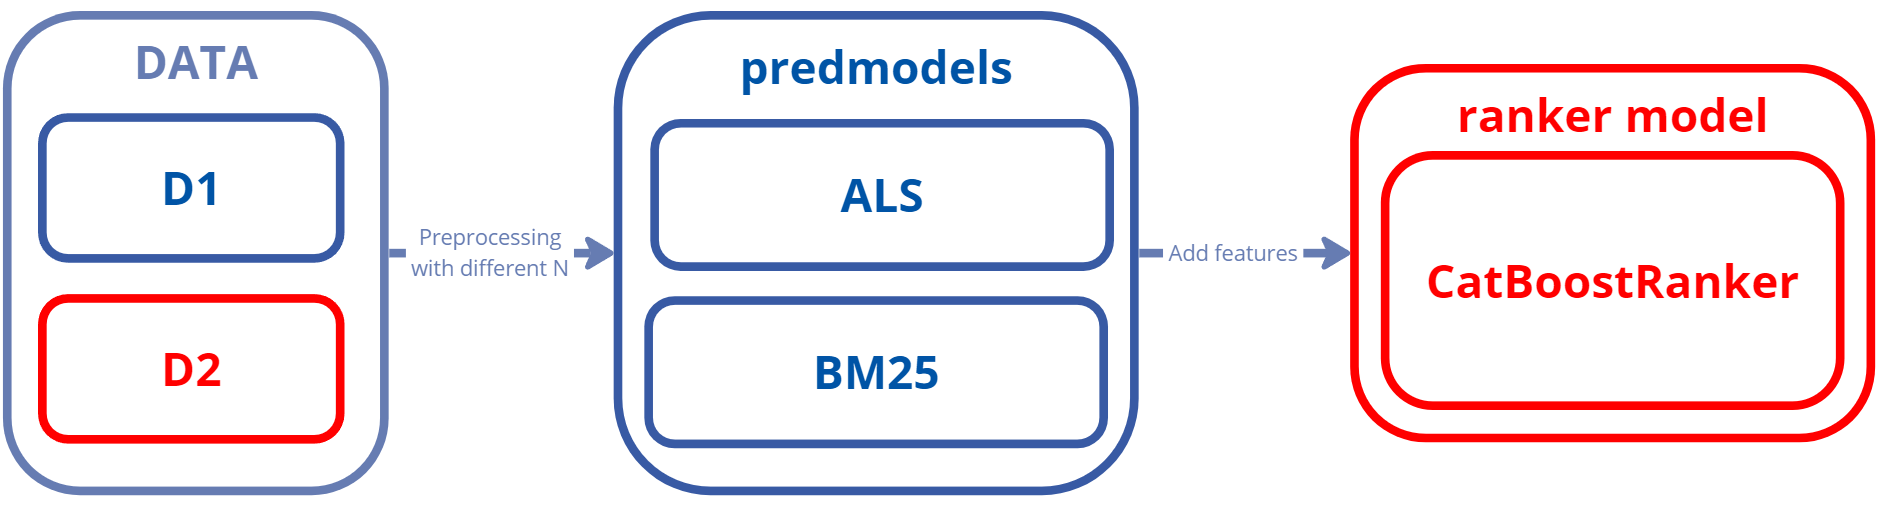

Мы используем двухэтапную модель для предсказаний в данном решении. На первом этапе (называемом этапом предмоделей) мы используем ансамбль моделей ALS и BM25 для отбора кандидатов и последующего ранжирования с помощь более сложной модели.


В нашем решении используются реализации этих алгоритмов из библиотеки implicit, которые отличаются скоростью и возможностью распараллелить вычисления на графическом ускорителе.

В числе прочего следует отметить разделение пользователей на две группы по количеству просмотров: для одной из них будет использоваться предсказание на основе моделирования, а для другой - на основе эвристик, описанных в классе ColdStart.

Второй этап решения - использование градиентного бустинга Catboost для ранжирования фильмов-кандидатов, полученных из предмоделей. Фильмам-кандидатам, которые пользователь дейтсвительно посмотрел, ставим label=1, иначе 0. В качестве признаков для катбуста используем информацию о пользователе, фильме и истории их взаимодействий. Для каждого пользователя на X истинных кандидатов случайно сэмплируем по X кандидатов, которые есть только в предсказании и ALS, и BM25

Перед рекомендацией для всех пользователей мы заново обучаем предмодели на всех данных.

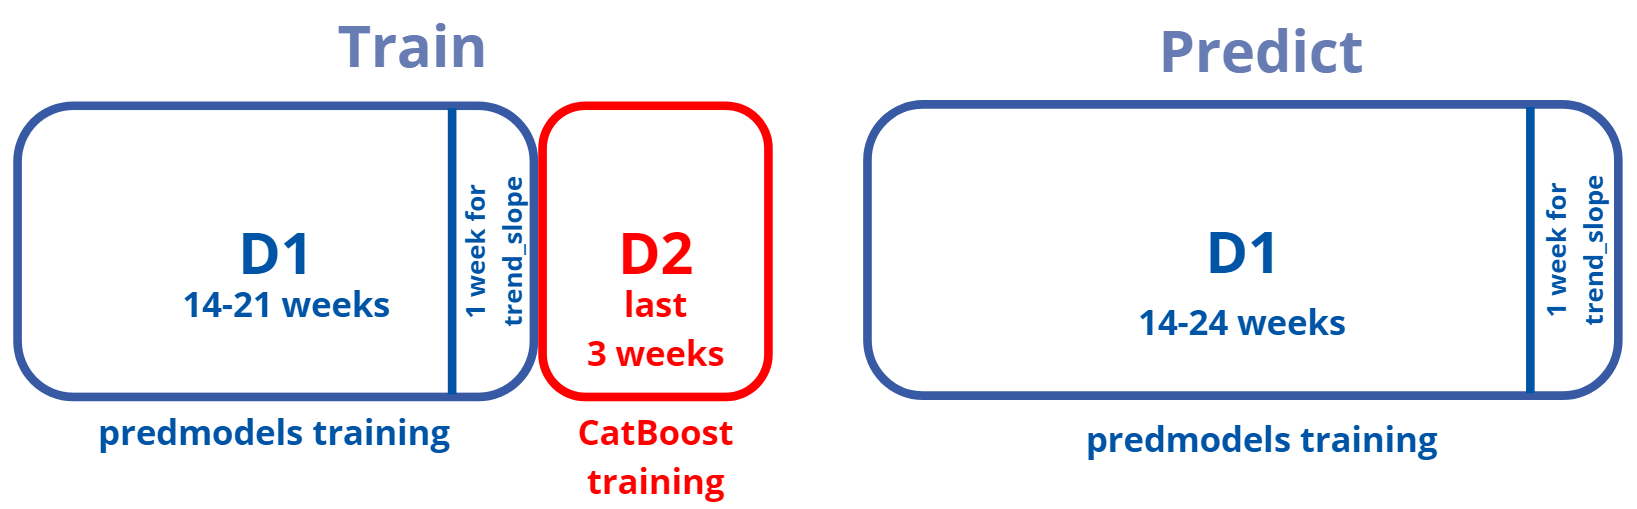

В процессе рекомендации для оптимизации потребления памяти мы идём по батчам в 10 тысяч пользователей. Для них сначала мы выбираем кандидатов с помощью предмоделей, а потом выдаём рекомендацию с помощью catboost'а или алгоритма холодного старта

# Dataset

Класс обёртка, позволяющий удобно работать с датасетом

In [1]:
import gc
import pandas as pd


class Dataset:
    def __init__(self, path_to_dataset: str):
        '''
            Конструктор класса, инициализирующий поля

            Параметры:
            ----------
            path_to_dataset: str
                Относительный путь до датасета
        '''

        self.path_to_dataset = path_to_dataset
        self.countries = None
        self.genres = None
        self.movies = None
        self.logs = None
        self.staff = None
        self.predict = None

    def read_data(self):
        '''
            Метод, считывающий и сохраняющий датасеты в поля класса
        '''

        self.countries = pd.read_csv(f'{self.path_to_dataset}countries.csv')
        self.genres = pd.read_csv(f'{self.path_to_dataset}genres.csv')
        self.movies = pd.read_csv(f'{self.path_to_dataset}movies.csv')
        self.logs = pd.read_csv(f'{self.path_to_dataset}logs.csv')
        self.staff = pd.read_csv(f'{self.path_to_dataset}staff.csv')

    def save_data(self):
        '''
            Метод, сохраняющий обработанные датасеты локально в формате .csv
        '''
        
        self.countries.to_csv(f'{self.path_to_dataset}countries_processed.csv', index=False)
        self.genres.to_csv(f'{self.path_to_dataset}genres_processed.csv', index=False)
        self.movies.to_csv(f'{self.path_to_dataset}movies_processed.csv', index=False)
        self.logs.to_csv(f'{self.path_to_dataset}logs_processed.csv', index=False)
        self.staff.to_csv(f'{self.path_to_dataset}staff_processed.csv', index=False)


# Preprocessing

Класс обёртка, объединяющий всю очистку и предобработку датасета

In [2]:
import json
import os

import ast
import numpy as np
import pandas as pd


class Preprocessing:
    def __init__(self, movies_views_threshold: int, users_watches_threshold: int):
        '''
            Конструктор

            Параметры:
            movies_views_threshold: int
                Порог просмотров, по которому мы обрезаем фильмы. Фильмы с меньшим кол-вом просмотров удаляются

            users_watches_threshold: int
                Порог просмотров, по которому мы обрезаем пользователей. Пользователи с меньшим кол-вом просмотренных фильмов не попадают в датасет

            Поля класса:
            new_movie_ids: Dict[int, int]
                Словарь, хранящий пары вида (оригинальный id фильма, новый id фильма)

            old_movie_ids: Dict[int, int]
                Словарь, хранящий пары вида (новый id фильма, оригинальный id фильма)

            staff_columns_names: List[str]
                Список колоннок, отвечающих за персонал 
        '''
        
        self.movies_views_threshold = movies_views_threshold
        self.users_watches_threshold = users_watches_threshold

        self.new_movie_ids = None
        self.old_movie_ids = None

        self.staff_columns_names = ['actor', 'producer', 'editor', 'director',
                                    'writer', 'composer', 'presenter', 'commentator']

    @staticmethod
    def day_part(hour):
        '''
            Функция, возвращающая часть дня взависимости от часа
        '''
        
        time_of_day = {
            (0,1,2,3,4,5): "night",
            (6,7,8,9,10,11): "morning",
            (12,13,14,15,16,17): "day",
            (18,19,20,21,22,23): "evening"
        }

        for hours, part in time_of_day.items():
            if hour in hours:
                return part

    @staticmethod
    def add_columns_to_df(df, columns):
        '''
            Функция, добавляющая новые столбцы в pd.DataFrame и заполняющия их NaN

            Параметры:
            columns: List[str]
                Список названий столбцов, которые надо добавить

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм, содержащий новые столбцы
        '''

        for column in columns:
            df[column] = np.nan
            df[column] = df[column].astype(object)

        return df

    @staticmethod
    def set_columns_types(df, columns, type_to_set):
        '''
            Функция, изменяющая тип определённым столбцам

            Параметры:
            columns: List[str]
                Список названий столбцов, тип которых надо изменить
            type_to_set: type
                Тип, который надо установить столбцам

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм, в котором требуемые столбцы имеют нужный тип
        '''

        df[columns] = df[columns].astype(type_to_set)

        return df

    def set_new_old_ids(self, movies_df, logs_df):
        '''
            Функция, обновляющая id фильмов. При этом заполняются поля класса new_movie_ids и old_movie_ids

            Параметры:
            movies_df: pd.DataFrame
                Датафрейм датасета с фильмами
            logs_df: pd.DataFrame
                Датафрейм датасета с логами

            Возвращаемое значение:
            pd.DataFrame, pd.DataFrame
                Датафреймы с фильмами и логами, в которых изменены movie_id
        '''

        self.new_movie_ids = { movies_df.id.iloc[i]: i for i in range(movies_df.shape[0]) }
        self.old_movie_ids = { self.new_movie_ids[i]: i for i in self.new_movie_ids }

        # заменяем id со старых на новые в датафреймах с фильмами и логами
        movies_df = movies_df.reset_index(drop=True)
        movies_df.id = movies_df.id.apply(lambda x: self.new_movie_ids[x])
        logs_df.movie_id = logs_df.movie_id.apply(lambda x: self.new_movie_ids[x])

        return movies_df, logs_df

    def make_datetime_features(self, logs_df):
        '''
            Создание фичей, связанных с датой и временем

            Параметры:
            logs_df: pd.DataFrame
                Датафрейм датасета с логами

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм с логами, в который добавлены временнЫе фичи 
        '''

        logs_df['day'] = logs_df['datetime'].dt.day
        logs_df['day_of_week'] = logs_df['datetime'].dt.day_of_week
        logs_df['day_of_year'] = logs_df['datetime'].dt.day_of_year
        logs_df['hour'] = logs_df['datetime'].dt.hour
        logs_df['day_part'] = logs_df['hour'].apply(self.day_part)
        logs_df['is_weekend'] = np.where(logs_df['day_of_week'].isin([5,6]), 1,0)
        logs_df['week_number'] = logs_df['datetime'].dt.isocalendar().week

        return logs_df
    
    @staticmethod
    def count_views_for_movie(logs_df, result_length):
        '''
            Подсчёт для каждого фильма, сколько уникальных пользователей посмотрело его

            Параметры:
            result_length: int
                Общее количество уникальных фильмов в датасете

            Возвращаемое значение:
            pd.Series
                Series, в котором каждому фильму сопоставленно количество уникальных зрителей 
        '''

        views_count = logs_df.groupby('movie_id')['user_id'].nunique()
        views_count = views_count.reindex(range(result_length), fill_value=0)

        return views_count
    
    @staticmethod
    def get_year_of_release(movies_df):
        '''
            Функция для получения года релиза каждого фильма

            Параметры:
            movies_df: pd.DataFrame
                Датафрейм датасета с фильмами

            Возвращаемое значение:
            List[int]
                Годы выходов каждого фильма в датасете 
        '''

        return pd.to_datetime(movies_df['year']).dt.year
    
    @staticmethod
    def filter_movies(movies_df, movies_views_threshold):
        '''
            Фильтрация фильмов по количеству просмотров

            Параметры:
            movies_views_threshold: int
                Порог просмотров, по которому мы обрезаем фильмы

            Возвращаемое значение:
            pd.DataFrame
                Очищенный датафрейм с фильмами
        '''

        movies_df = movies_df[movies_df.views > movies_views_threshold]

        return movies_df
    
    @staticmethod
    def clear_logs_from_missing_movies(logs_df, movies_df):
        '''
            Очистка логов от записей, в которых содержатся несуществующие фильмы

            Параметры:
            logs_df: pd.DataFrame
                Датафрейм с логами
            movies_df: pd.DataFrame
                Датафрейм с фильмами

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм с удалёнными логами об очищенных фильмах
        '''

        logs_df = logs_df[logs_df.movie_id.isin(movies_df.id)]

        return logs_df


    @staticmethod
    def group_aggregate_logs(logs_df):
        '''
            Применение определённых функций аггрегации к датасету с логами

            Параметры:
            logs_df: pd.DataFrame
                Датафрейм с логами

            Возвращаемое значение:
            pd.DataFrame
                Проаггрегированный датафрейм с логами
        '''

        return logs_df.groupby(['user_id', 'movie_id'], as_index=False, sort=False).agg({
                'datetime': 'first',
                'duration': 'sum',
                'day': 'first',
                'day_of_week': 'first',
                'day_of_year': 'first',
                'hour': 'first',
                'day_part': 'first',
                'is_weekend': 'first',
                'week_number': 'first'
            }).reset_index(drop=True)
    
    @staticmethod
    def add_countries_genres_data_to_logs(logs_df, movies_df):
        '''
            Добавление в датасет с логами данных о стране производства и жанре фильма

            Параметры:
            logs_df: pd.DataFrame
                Датафрейм с логами
            movies_df: pd.DataFrame
                Датафрейм с фильмами

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм с логами, в котором для каждой записи добавлена информации о стране производства и жанре
        '''

        ids = movies_df.id.unique().tolist()

        for i in ids:
            ids_in_logs = logs_df[logs_df.movie_id == i].index.tolist()  # id логов о просмотре данного фильма
            movie_info = movies_df.loc[movies_df.id == i]

            for j in ['genres', 'countries']:
                # список в формате строки, поэтому надо его спарсить в list
                value = movie_info[j].values[0][1:-1].split(',')

                if value != ['']:
                    for k in ids_in_logs:
                        logs_df.at[k, j] = value

        return logs_df

    @staticmethod
    def split_staff_by_role_movies(movies_df, staff_df, staff_columns):
        '''
            Добавление в датасет с фильмами id персонала в отдельные столбцы профессий

            Параметры:
            movies_df: pd.DataFrame
                Датафрейм с фильмами
            staff_df: pd.DataFrame
                Датафрейм с персоналом
            staff_columns: List[str]
                Список колоннок, отвечающих за персонал 

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм с фильмами, в котором добавлены столбцы с id персонала по профессиям
        '''

        ids = movies_df.id.unique().tolist()
        for i in ids:
            # список в формате строки, поэтому надо его спарсить в list
            list_of_staff = json.loads(movies_df.staff.loc[i])

            if len(list_of_staff):
                df_for_movie = staff_df.loc[staff_df.id.isin(list_of_staff)]
                
                for j in staff_columns:
                    movies_df.at[i, j] = df_for_movie[df_for_movie.role == j].id.to_list()

        return movies_df

    @staticmethod
    def filter_logs_by_users_watches(logs_df, users_watches_threshold):
        '''
            Фильтрация логов по количеству просмотров от каждого пользователя

            Параметры:
            logs_df: pd.DataFrame
                Датафрейм с логами
            users_watches_threshold: int
                Граничное количество просмотров 

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм с логами, в котором у всех пользователей больше users_watches_threshold просмотров
        '''

        return logs_df.groupby('user_id').filter(lambda x: len(x) > users_watches_threshold)

    def preprocess(self, dataset):
        '''
            Метод, объединяющий в себе всю очистку и предобработку

            Параметры:
            dataset: Dataset
                экземпляр класса со всеми датафреймами

            Возвращаемое значение:
            Dataset
                предобработанный датасет
        '''

        dataset.logs['datetime'] = pd.to_datetime(dataset.logs['datetime'], format='mixed')
        dataset.logs = self.make_datetime_features(dataset.logs)

        dataset.logs = self.set_columns_types(dataset.logs, ['user_id', 'movie_id'], int)

        dataset.movies['views'] = self.count_views_for_movie(dataset.logs, dataset.movies.shape[0])
        dataset.movies['year'] = self.get_year_of_release(dataset.movies)

        dataset.movies = self.filter_movies(dataset.movies, self.movies_views_threshold)
        dataset.logs = self.clear_logs_from_missing_movies(dataset.logs, dataset.movies)

        dataset.logs = dataset.logs.sort_values('datetime')
        dataset.logs = self.group_aggregate_logs(dataset.logs)

        dataset.logs = self.add_columns_to_df(dataset.logs, ['genres', 'countries'])
        dataset.logs = self.add_countries_genres_data_to_logs(dataset.logs, dataset.movies)

        dataset.movies = self.add_columns_to_df(dataset.movies, self.staff_columns_names)
        dataset.movies = self.split_staff_by_role_movies(dataset.movies, dataset.staff, self.staff_columns_names)

        dataset.movies, dataset.logs = self.set_new_old_ids(dataset.movies, dataset.logs)

        dataset.logs = self.filter_logs_by_users_watches(dataset.logs, self.users_watches_threshold)

        return dataset
    
    @staticmethod
    def prep(text, bad_set):
        '''
            Вспомогательная функция, удаляющая все "плохие" символы из текста

            Параметры:
            text: List[str]
                Список текстов, в которых надо удалить "плохие" строки
            bad_set: str
                Список "плохих" символов

            Возвращаемое значение:
            List[str]
                Очищенный список text
        '''

        for c in bad_set:
            if c in text:
                text = text.replace(c, '')
        return text

    def make_description_features(self, movies_df):
        '''
            Метод, создающий текстовые фичи по описанию фильмов

            Параметры:
            movies_df: pd.DataFrame
                Датафрейм с фильмами

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм, в котором есть 2 столбца: описание фильмов, очищенное от цифр и не кириллицы, и количество жанров для каждого фильма
        '''

        local_df = movies_df[['id','name', 'description', 'genres']]
        genres = local_df.genres.to_list()
        new_gen = []

        for i in range(len(genres)):
            new_gen.append(eval(genres[i]))

        local_df['len_genres'] = [len(i) for i in new_gen]
        local_df['description'] = local_df.description.apply(str).apply(lambda s: s.lower())
        bad_set = set(local_df.description.sum())
        bad_set2 = ''

        for c in bad_set:
            if c not in ' йцукенгшщзхъфывапролджэячсмитьбю':
                bad_set2 += c

        local_df['description'] = local_df.description.apply(lambda x: self.prep(x, bad_set2))

        return local_df[['description', 'len_genres']]
    
    @staticmethod
    def add_all_staff_actors_directors(movies_df):
        '''
            Метод, преобразующий столбцы с персоналом, актёрами, режиссёрами в строки

            Параметры:
            movies_df: pd.DataFrame
                Датафрейм с фильмами

            Возвращаемое значение:
            pd.DataFrame
                Датафрейм с фильмами, в котором столбцы с персоналом, актёрами, режиссёрами - строки
        '''

        all_staff = movies_df['staff'].apply(lambda x: set(x))
        all_actors = movies_df['actor'].fillna('[]').apply(lambda x: set(x))
        all_directors = movies_df['director'].fillna('[]').apply(lambda x: set(x))

        for movie_id in movies_df.id:
            # оставляем в персонале всех, кроме актёров и режиссёров
            movies_df.loc[movie_id, 'staff'] = str(list(all_staff[movie_id] - (all_actors[movie_id] | all_directors[movie_id])))

        # если честно, я не знаю, почему разные обработки, я не помню писал ли это я или кто-то другой, но оно работает)
        movies_df['staff'] = movies_df['staff'].apply(lambda x: x.replace(',', '').replace('[', '').replace(']', ''))

        movies_df['director'] = movies_df['director'].fillna('').apply(list).apply(lambda x: ' '.join(map(str, x)))
        movies_df['actor'] = movies_df['actor'].fillna('').apply(list).apply(lambda x: ' '.join(map(str, x)))
        return movies_df

# Feature Creation

Конечная подготовка данных для обучения catboost.

In [3]:
import numpy as np
import pandas as pd


class FeatureCreator:
    def __init__(self, production_version: bool, n_weeks_for_catboost: int) -> None:
      '''
        Конструктор ц

        Параметры:
        ----------
        production_version: bool
            переменная обозначающая этап разработки: обучение или тестирование(запуск)
        n_weeks_for_catboost: int
            переменная, обозначающая количество недель, которые берутся за основу для тестирования
      '''
      self.production_version = production_version
      self.n_weeks_for_catboost = n_weeks_for_catboost

    @staticmethod
    def activation_function(x):
      '''
        Смысл заключается в приближении к нулю если значение менее половины

        ---
        x:float
           вероятность
        Возвращаемое занчение 
          float - смещенная вероятность
      '''
      if x < 1/2:
          return 1 / (1 + np.exp(-10 * (x - 1/2)))
      else:
          return 1 / (1 + np.exp(-3.6 * (x - 1/2)))

    @staticmethod
    def get_movie_rating(x):
      '''
        Целочисленная часть от вероятности умноженной на 5

        ---
        x:
          float - вероятность
        Возвращаемое значение:
          int - условную оценку пользователем фильма по шкале от 0 до 5.
      '''
      return np.ceil(x * 5)

    # Смысл методов smooth, trend_slope, make_trend_slope_with_watches_in_time заключается в создании признаков, характеризующих просматриваемость в рамках каждого из дней недели. Сумма дней недели равна 1.
    @staticmethod
    def smooth(series, window_size, smoothing_func):
      '''
        Смысл методов smooth, trend_slope, make_trend_slope_with_watches_in_time заключается в создании признаков, 
        характеризующих просматриваемость в рамках каждого из дней недели. Сумма дней недели равна 1.

        ---
        series: list[int] - признак, представляющий из себя временной ряд
        window_size:int - с каким периодом использовать сглаживание
        smoothing_func:function - непосредственно функция сглаживания
      '''
      series = np.array(series)
      ext = np.r_[
          2 * series[0] - series[window_size - 1::-1],
          series,
          2 * series[-1] - series[-1:-window_size:-1],
      ]
      weights = smoothing_func(window_size)
      smoothed = np.convolve(weights / weights.sum(), ext, mode="same")
      return smoothed[window_size:-window_size + 1]

    def trend_slope(self, series, window_size=7, smoothing_func=np.hamming):
        '''
          series:List[int] - признак, представляющий из себя временной ряд
          window_size:int - с каким периодом использовать сглаживание
          smoothing_func:function - непосредственно функция сглаживания
        '''
        smoothed = self.smooth(series, window_size, smoothing_func)
        return smoothed[-1] - smoothed[-2]

    def make_trend_slope_with_watches_in_time(self, logs_df, movies_df, window_time=7):
        '''
          logs_df:pd.DataFrame - таблица с подготовленными данными истории действий(логов)
          movies_df:pd.DataFrame - таблица с подготовленными данными сведений о фильме
          window_time:int - период
        '''

        item_stats = movies_df[["id"]].set_index("id") # обозначаем данную колонку как идентификатор строки в DataFrame
        max_date = logs_df["day_of_year"].max() # определяем самую позднюю дату содержащуюся в истории 
        cols = list(range(window_time)) # создаем список длиной = периоду который мы будем анализировать(здесь, неделя)
        # добавляем колонки на основе cols
        for col in cols:
            watches = logs_df[
                logs_df["day_of_year"] == max_date - (window_time - 1 - col)
                ]
            item_stats = item_stats.join(
                watches.groupby("movie_id")["user_id"].count(), lsuffix=col
            )
        item_stats.fillna(0, inplace=True)
        new_colnames = ["user_id" + str(i) for i in range(1, window_time)] + ["user_id"]
        # создаем статистики на каждый день недели с помощью функции trend_slope
        trend_slope_to_row = lambda row: self.trend_slope(row[new_colnames], window_size=window_time)
        item_stats["trend_slope_in_7_days"] = item_stats.apply(trend_slope_to_row, axis=1)
        item_stats["watched_in_7_days"] = item_stats[new_colnames].apply(sum, axis=1) # сколько по времени смотрел пользователь фильмы в течении недели

        if 'trend_slope_in_7_days' in movies_df.columns:
            movies_df = movies_df.drop(["trend_slope_in_7_days", "watched_in_7_days"], axis=1)

        movies_df = movies_df.merge(
            item_stats[["trend_slope_in_7_days", "watched_in_7_days"]], left_on='id',
            right_index=True)

        return movies_df

    @staticmethod
    def count_user_total_watch_duration(logs_df):
      '''
          Добавляет новый признак на основе исторических данных. В данном случае сумма времени просмотра всеми пользователями

          ---
          logs_df:pd.DataFrame - таблица с подготовленными данными истории действий(логов)
      '''
      sum_duration = pd.DataFrame(logs_df.groupby(['user_id', 'movie_id'])['duration'].sum())
      sum_duration.reset_index(inplace=True)

      return sum_duration

    @staticmethod
    def get_approximate_mean_duration(sum_df):
      '''
          Создает признаки на основе длительности просмотров.
          А именно, смещенное максимальное и среднее арифметическое значение длительности.
          
          ---
          sum_df:pd.DataFrame - таблица с подготовленными данными истории действий(логов)
      '''
      approx_duration = sum_df.groupby('movie_id')['duration'].quantile(0.9)
      mean_duration = sum_df.groupby('movie_id')['duration'].mean()

      return approx_duration, mean_duration

    @staticmethod
    def add_duration_features_in_movies(movies_df, approx_duration, mean_duration):
        '''
          Добавляет в исходный в исходную таблицу данных о фильмах признаки из get_approximate_mean_duration

          ---
          movies_df:pd.DataFrame - таблица с подготовленными данными сведений о фильме
          approx_duration:pd.Series - смещенное максимальное значение длительности просмотров
          mean_duration:pd.Series - среднее арифмитическое значение длительности просмотров
        '''

        movies_df['approx_duration'] = movies_df['id'].apply(lambda x: approx_duration[x] if x in approx_duration else np.nan)
        movies_df['mean_duration'] = movies_df['id'].apply(lambda x: mean_duration[x] if x in mean_duration else np.nan)
        movies_df['mean_percentage'] = movies_df['mean_duration'] / movies_df['approx_duration'] * 100

        return movies_df

    def add_duration_features_in_logs(self, logs_df, movies_df):
        '''
          Добавляет в исходный в исходную таблицу данных о фильмах признаки из get_approximate_mean_duration

          ---
          movies_df:pd.DataFrame - таблица с подготовленными данными сведений о фильме
          mean_duration:pd.Series - смещенное максимальное значение длительности просмотров
          mean_duration:pd.Series - среднее арифмитическое значение длительности просмотров
        '''

        logs_df['percent_of_watch'] = np.zeros(logs_df.shape[0])
        movies_ids = movies_df.id.unique().tolist()

        for id in movies_ids:
            logs_df.loc[logs_df.movie_id == id, 'percent_of_watch'] = (logs_df.loc[logs_df.movie_id == id, 'duration'] / \
                                                                       movies_df.loc[
                                                                           movies_df.id == id, 'approx_duration'].values[0])

        logs_df['score'] = logs_df['percent_of_watch'].apply(self.activation_function)
        logs_df['rating'] = logs_df['score'].apply(self.get_movie_rating)

        return logs_df

    @staticmethod
    def add_score_features_in_movies(logs_df, movies_df):
        '''
          Добавляем статистики на основе исторических данных просмотров для каждого фильма
          mean - среднее арифметическое,
          std - стандартное отклонение (корень из дисперсии),
          25 и 75 квантили - если мы отсортируем массив значений и возьмем значения которые стоят на позициях 0.25*(длину массива) или 0.75*(длину массива)

          ---
          logs_df:pd.DataFrame - таблица с подготовленными данными истории действий(логов)
          movies_df:pd.DataFrame - таблица с подготовленными данными сведений о фильме
        '''
        movies_scores = logs_df.groupby('movie_id').agg({'score': ['mean', 'median', 'std', lambda x: x.quantile(0.25),
                                                                   lambda x: x.quantile(0.75)]}).sort_index()
        ratings_count = logs_df.groupby('movie_id')['rating'].value_counts(normalize=True).unstack().sort_index().fillna(0)

        movies_scores.columns = ['mean_score', 'median_score', 'std_score', 'q25_score', 'q75_score']
        ratings_count.columns = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']

        movies_df = movies_df.merge(movies_scores, left_on='id', right_index=True, how='outer')
        movies_df = movies_df.merge(ratings_count, left_on='id', right_index=True, how='outer')

        return movies_df

    def make_dataset_split(self, logs_df):
        '''
          Добавляем статистики на основе исторических данных просмотров при разделении исходного датасета на тренировочную и тестовые(валидационную и конечное тестирование) выборки

          ---
          logs_df:pd.DataFrame - таблица с подготовленными данными истории действий(логов)
          self.production_version - отвечает за обозначение версии разработки(True - стадия использования, False - стадия подготовки, обучения)
          self.n_weeks_for_catboost - количество недель, которые берутся за основу для тестирования
          d1 - таблица с историческими данными, на которых построены аналитические признаки
          d2 - таблица с историческими данными, на которых будет проверно рещение 
        '''
        if self.production_version:
            d1, d2 = logs_df[logs_df.week_number < logs_df.week_number.max() - self.n_weeks_for_catboost], logs_df[
                logs_df.week_number >= logs_df.week_number.max() - self.n_weeks_for_catboost]
            d2 = d2[d2.user_id.isin(d1.user_id.unique())]
            # d1 = d1[d1.user_id.isin(d2.user_id.unique())]

            return d1, d2, None
        else:
            df, test_test = logs_df[logs_df.week_number < logs_df.week_number.max() - 2], logs_df[logs_df.week_number >= logs_df.week_number.max() - 2]
            d1, d2 = df[df.week_number < df.week_number.max() - self.n_weeks_for_catboost], df[df.week_number >= df.week_number.max() - self.n_weeks_for_catboost]
            d2 = d2[d2.user_id.isin(d1.user_id.unique())]
            return d1, d2, test_test

    def add_duration_features_in_train_test(self, train_df, test_df, movies_df):
        '''
          Добавление колонок с признаками для каждой из выборок и таблицы с сведениями о фильмах
          ---
          train_df:pd.DataFrame - тренировочная выборка из logs_df
          test_df:pd.DataFrame - тестовая выборка из logs_df
          movies_df:pd.DataFrame - таблица с неподготовленными данными сведений о фильме
        '''
        train_df = self.add_duration_features_in_logs(train_df, movies_df)
        movies_df = self.add_score_features_in_movies(train_df, movies_df)
        test_df = self.add_duration_features_in_logs(test_df, movies_df)

        return train_df, test_df, movies_df

    def make_features(self, dataset):
        '''
          Добавляет в исходный в исходную таблицу данных о фильмах признаки из get_approximate_mean_duration

          ---
          movies_df:pd.DataFrame - таблица с подготовленными данными сведений о фильме
          approx_duration:pd.Series - смещенное максимальное значение длительности просмотров
          mean_duration:pd.Series - среднее арифмитическое значение длительности просмотров
        '''
        sum_duration = self.count_user_total_watch_duration(dataset.logs)
        approx_duration, mean_duration = self.get_approximate_mean_duration(sum_duration)

        dataset.movies = self.add_duration_features_in_movies(dataset.movies, approx_duration, mean_duration)

        return dataset

    def split(self, dataset):
        '''
          Разделяет исходную таблицу на тренировочные и тестовые выборки и добавляет к ней признаки

          ---
          dataset:pd.DataFrame - таблица с подготовленными данными истории действий(логов)
        '''
        train_df, test_df, test_test = self.make_dataset_split(dataset.logs)
        train_df, test_df, dataset.movies = self.add_duration_features_in_train_test(train_df, test_df, dataset.movies)

        dataset.movies = self.make_trend_slope_with_watches_in_time(train_df, dataset.movies)

        return train_df, test_df, test_test, dataset

    @staticmethod
    def get_movies_features(train_df, movies_df, new_movie_ids):
        '''
          Разделяет исходную таблицу на тренировочные и тестовые выборки и добавляет к ней признаки

          ---
          train_df:pd.DataFrame - таблица с подготовленными данными истории действий(логов)
          movies_df:pd.DataFrame - таблица с подготовленными данными сведений о фильмах
          new_movie_ids:pd.Series - список идентификаторов в таблице сведений о фильмах
        '''
        mean_watch_time = train_df.groupby('movie_id')['duration'].mean()
        sum_watch_time = train_df.groupby('movie_id')['duration'].sum()
        popularity = train_df['movie_id'].value_counts()
        # movies_df.index = movies_df.id

        for movie_id in new_movie_ids.values():
            if movie_id not in mean_watch_time:
                mean_watch_time[movie_id] = 0
                sum_watch_time[movie_id] = 0
                popularity[movie_id] = 0

        return mean_watch_time, sum_watch_time, popularity, movies_df

    @staticmethod
    def get_catboost_target(test_df):
        '''
          Преобразует таблицу, в данные, которые может использовать catboost для обучения

          ---
          test_df:pd.DataFrame - таблица с подготовленными данными истории действий(логов)
        '''
        correct_candidates_valid = test_df.groupby('user_id')['movie_id'].agg(list)

        return correct_candidates_valid



# Cold start

Простой алгоритм, предлагающий фильмы пользователям, которым мы не можем ничего предсказать с помощью catbooost'а

In [4]:
import json
from collections import Counter


class ColdStartRecommender:
    def __init__(self, implementation='global', local_logs_df=None):
        '''
            Конструктор

            Параметры:
                implementation: str
                    Вид реализации: global - на всех логах, local - на логах за определённый период времени
                local_logs_df: pd.Series
                    В случае, если выбрана локальная реализация - pd.Series, в котором для фильмов посчитано кол-во просмотров за период, и они отсортированы по нему
        '''

        self.implementation = implementation
        self.local_logs_df = local_logs_df

    def recommend(self, logs_df, movies_df, user_id, top_n=10):
        '''
            Функция, рекомендующая top_n фильмов для пользователя с user_id, основываясь на его самых просматриваемых жанрах

            Параметры:
                logs_df: pd.DataFrame
                    Датафрейм с датасетом логов
                movies_df: pd.DataFrame
                    Датафрейм с датасетом фильмов
                user_id: int
                    id пользователя, для которого надо порекомендовать фильмы
                top_n: int
                    Кол-во фильмов в рекомендации
        '''
                
        user_watched_films = logs_df[logs_df.user_id == user_id].movie_id.unique()

        watched_movies = movies_df[movies_df.id.isin(user_watched_films)]
        unwatched_movies = movies_df[~movies_df.id.isin(user_watched_films)]

        watched_genres = []

        for movie in watched_movies.iterrows():
            watched_genres.extend(json.loads(movie[1].genres))

        favourite_genres = [genre_id for genre_id, _ in Counter(watched_genres).most_common(10)]

        if len(favourite_genres):
            top_genres_movies = unwatched_movies[unwatched_movies.genres.apply(lambda x: len(set(json.loads(x)) & set(favourite_genres)) > 0)]

            if len(set(self.local_logs_df.index) & set(top_genres_movies.id.unique())) >= top_n:
                unwatched_movies = top_genres_movies

        if self.implementation == 'global':
            return unwatched_movies.sort_values('views', ascending=False).head(top_n).id.values
        elif self.implementation == 'local':
            local_top = self.local_logs_df[self.local_logs_df.index.isin(unwatched_movies.id.unique())]
            return list(local_top.head(top_n).index.values.astype(int))
        else:
            raise KeyError

# Predmodels

Первый этап получения предикта - использование предмоделей для сужения спектра ранжирования с нескольких тысяч фильмов до разумного количества. Так же мы получаем новые фичи, благодаря ранжированию с помощью предмоделей.

Проблема с которой мы столкнулись в самом начале решения - дизбаланс количества данных с историей и без нее. Так как модели implicit взаимодействия очень сильно зависят от количества исторических данных, то было принято решение использовать разное количество кандидатов для юзеров, которые посмотрели небольшое количество фильмов и достаточное для нормального предикта.

In [5]:
import implicit
from scipy import sparse


class PredModels:
    """
    Класс с предмоделями.

    Parameters
    ----------
    n_pred_candidates_few : int
    Количество кандидатов для юзеров с малым количеством просмотров.

    n_pred_candidates_a_lot : int
    Количество кандидатов для юзеров с большой историей.

    pred_models_n_threshold : int
    Пороговое значение по количеству просмотров. Разбиение на людей с малой историей и большой.
    """
    def __init__(self, n_pred_candidates_few: int, n_pred_candidates_a_lot: int, pred_models_n_threshold: int):
        self.n_pred_candidates_few = n_pred_candidates_few
        self.n_pred_candidates_a_lot = n_pred_candidates_a_lot
        self.pred_models_n_threshold = pred_models_n_threshold
        self.items = None
        self.ids = None
        self.model_nn = None
        self.model_als = None
        self.cooc_models = None

    @staticmethod
    def make_sparse_matrix(train_df):
        """
        Библиотека implicit треубет на вход sparce_matrix.
        Функция для создания матрицы для implicit.

        Parameters
        ----------
        train_df : DataFrame
        DataFrame из которого треубется создание sparce matrix.

        Returns
        -------
        sparce_matrix
        Разряженная матрица взаимодействий
        """
        enum_items = np.array(train_df["movie_id"].values).astype(int)
        enum_users = np.array(train_df["user_id"].values)

        sparse_matrix = sparse.csr_matrix(
            (np.ones(shape=(len(enum_users))), (enum_users, enum_items)),
        )

        return sparse_matrix

    @staticmethod
    def outer_merge(first_dataframe: pd.DataFrame, second_dataframe: pd.DataFrame) -> pd.DataFrame:
        """
        Объединение одинаковых столбцов.

        Parameters
        ----------
        first_dataframe : pd.DataFrame
        Первый dataframe для объединения.

        second_dataframe: pd.DataFrame
        Второй dataframe для объединения.

        Returns
        -------
        pd.DataFrame
        Объединеннный dataframe.
        """
        common_columns = list(set(first_dataframe.columns) & set(second_dataframe.columns))
        return pd.merge(first_dataframe, second_dataframe, on=common_columns, how='outer')

    def set_items_and_ids(self, train_df):
        """
        Получение всех фильмов и id для построения sparce_matrix конкретного юзера.

        Parameters
        ----------
        train_df : pd.DataFrame
        Dataframe из которого будут браться id фильмов и юзеров.
        """
        self.items = train_df.groupby('user_id')['movie_id'].agg(list)
        self.ids = train_df.user_id.unique()
    
    def prepare_data_for_models(self, train_df):
        """
        Подготовка данных. Создание общей sparce_matrix и индивидуальных значений.

        Parameters
        ----------
        train_df : pd.DataFrame
        Dataframe для расчета.

        Returns
        -------
        sparce_matrix
        Разряженная матрица взаимодействий
        """        
        sparse_matrix = self.make_sparse_matrix(train_df)

        self.set_items_and_ids(train_df)

        return sparse_matrix
    
    def predict_user_with_implicit(self, model, user_id, user_items, user_watches_count):
        """
        Рассчет кандидатов для каждого юзера.

        Parameters
        ----------
        model : implicit.model
        Модель для предсказания кандидатов.

        user_id : int
        Id юзера для подсчета кандидатов.

        user_items : list[int]
        Список фильмов, просмотренных юзером.

        user_watches_count : list[int]
        Список с колисетвом фильмов, просмотренных юзером.

        Returns
        -------
        list[int]
        Список кандидатов
        """  
        enum_users = np.zeros(len(user_items)).astype(int)
        enum_items = np.array(list(user_items)).astype(int)

        cur_sparse_matrix = sparse.csr_matrix(
            (np.ones(shape=(len(enum_users))), (enum_users, enum_items))
        )

        if user_watches_count[user_id] < self.pred_models_n_threshold:
            N = self.n_pred_candidates_few
        else:
            N = self.n_pred_candidates_a_lot

        rec = model.recommend(user_id, cur_sparse_matrix, N=N, recalculate_user=False,
                        filter_already_liked_items=True)

        idx = range(len(rec[0]))
        idx = sorted(idx, key=lambda x: rec[1][x], reverse=True)
        return list(zip(rec[0][idx], rec[1][idx]))

    def fit_predmodels(self, sparse_matrix):
        """
        Обучение предмоделей.

        Parameters
        ----------
        sparse_matrix : scipy.sparse
        Матрица взаимодействий всех юзеров.
        """ 
        self.model_nn = implicit.nearest_neighbours.BM25Recommender(210, 1.1, 0.4)
        self.model_nn.fit(sparse_matrix)

        self.model_als = implicit.als.AlternatingLeastSquares(
                            factors=20, alpha=13, random_state=42
                        )
        self.model_als.fit(sparse_matrix)

    def get_candidates(self, ids_to_get, user_watches_count):
        """
        Получение кандидатов по нужным id.

        Parameters
        ----------
        ids_to_get : list[int]
        id для которых надо рассчитать канидатов.

        user_watches_count : list[int]
        Список c количеством фильмов, просмотренных юзером.

        Returns
        -------
        predicted_candidates_nn : dict{int: list[int]}
        Список кандидатов по нужному id для модели bm25.

        predicted_candidates_als : dict{int: list[int]}
        Список кандидатов по нужному id для модели als.
        """  
        predicted_candidates_nn = {}
        predicted_candidates_als = {}

        for user_id in ids_to_get:
            if user_id in self.ids:
                candidates_nn = self.predict_user_with_implicit(self.model_nn, user_id, self.items[user_id], user_watches_count)
                candidates_als = self.predict_user_with_implicit(self.model_als, user_id, self.items[user_id], user_watches_count)
            else:
                candidates_nn = []
                candidates_als = []

            predicted_candidates_nn[user_id] = candidates_nn
            predicted_candidates_als[user_id] = candidates_als

        return predicted_candidates_nn, predicted_candidates_als

    def prepare_fit_predict(self, train_df, user_watches_count):
        """
        Подготовка + обучение + предикт кандидатов.

        Parameters
        ----------
        train_df : pd.DataFrame
        DataFrame для обучения предмоделей.

        user_watches_count : list[int]
        Список c количеством фильмов, просмотренных юзером.

        Returns
        -------
        predicted_candidates_nn : dict{int: list[int]}
        Список кандидатов по нужному id для модели bm25.

        predicted_candidates_als : dict{int: list[int]}
        Список кандидатов по нужному id для модели als.
        """ 
        sparse_matrix = self.prepare_data_for_models(train_df)
        self.fit_predmodels(sparse_matrix)
        
        candidates_nn, candidates_als = self.get_candidates(self.ids, user_watches_count)
        

        return candidates_nn, candidates_als
    
    def get_als_item_factor(self):
        """
        Получение item_factor как фичу от als для последующего использования.
        """
        return self.model_als.item_factors

# Catboost

Второй этап решения - использование градиентного бустинга Catboost для ранжирования фильмов-кандидатов, полученных из предмоделей. Фильмам-кандидатам, которых пользователь дейтсвительно посмотрел, ставим label=1, иначе 0. В качестве фичей для катбуста используем информацию о пользователе, фильме и истории их взаимодействий. Для каждого пользователя на X истинных кандидатов случайно сэмплируем по X кандидатов, которые есть только в предсказании ALS, только в предсказании BM25, в обоих.

Общие фичи:
* Оценка (score) релевантности фильма для этого пользователя, расчитанная моделями ALS и BM25
* Оценка фильма предмоделями, делённая на максимальную
* Ранг фильма для этого пользователя (какой по счёту он в топе вероятности для этого пользователя), исходя из моделей ALS и BM25
* Популярность фильма: к-во просмотров и к-во просмотров, делённое на максимальное
* Разница в днях между релизом фильма и фиксированной точкой в настоящем
* Суммарное время просмотра фильма и время просмотра, делённое на максимальное
* Среднее время просмотра фильма и среднее время просмотра, делённое на максимальное
* Расчёт статистик (mean, min, max, std) схожести фильмов-кандидатов и фильмов из истории просмотра
* Описание фильмов, список id жанров, актёров, режиссёров в качестве текстовых фичей

Фичи конкретно для фильмов:
* Угол наклона линии тренда фильма за последнюю неделю
* Количество просмотров у фильма за последнюю неделю
* Приблизительная длительность фильма (90-й персентиль времени просмотра фильма)
* Сколько минут в среднем смотрят этот фильм
* Средний процент просмотра фильма
* Статистики по проценту просмотра фильма после применения функции активации: среднее, медиана, стандартное отклонение, квантили
* Процент просмотра фильма, переведённый в шкалу от 1 до 5 и доля категорий 1-5 для каждого фильма

In [ ]:
import json

import numpy as np
import pandas as pd
import polars as pl
from tqdm.auto import tqdm
from functools import partial

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostRanker, Pool

class CatboostModel:
    def __init__(self, path_to_dataset: str, pred_models, catboost_train_size: float) -> None:
        """
          :param path_to_dataset Путь для сохранения весов модели.
          :type path_to_dataset: str
          :param pred_models Обученные предмодели.
          :param catboost_train_size Размер обучающей выборки в сравнении с валидационной (число от 0.0 до 1.0).
          :type catboost_train_size: float
        """
        self.path_to_dataset = path_to_dataset
        self.pred_models = pred_models
        self.catboost_train_size = catboost_train_size

        self.SIMILARITY_AGGS_MAP = {
            'similarity_mean': partial(np.mean, axis=1),
            'similarity_min': partial(np.min, axis=1),
            'similarity_max': partial(np.max, axis=1),
            'similarity_std': partial(np.std, axis=1),
            'similarity_var': partial(np.var, axis=1),
        }
        self.catboost_model = None

        self.cat_features = None
        self.features_to_drop = None
        self.text_features = None
        self.all_column_names_train = None
        self.user_id_without_predmodels = []

    @staticmethod
    def calculate_similarities(item_factors, user_candidates, user_history):
        """
          :param item_factors: np.array, списки фильмов для какого-либо пользователя.
          :param user_candidates: np.array, список кандидатов.
          :param user_history: np.array, список пользователей.
          :return: Значения сходства между кандидатами и историей просмотров пользователя.
        """
        return cosine_similarity(item_factors[user_candidates], item_factors[user_history])

    def calculate_similarity_stats(self, candidates, history):
        """
          :param candidates: np.array, список значений для кандидатов.
          :param history: np.array, список значений пользователей.
          :return: При матричном умножении данных массивов получаем итоговые вероятности.
        """
        res = self.pred_models.model_nn.similarity[candidates] * self.pred_models.model_nn.similarity[history].T
        return res.toarray()

    @staticmethod
    def make_train_test_split(ids, train_size):
        """
          Выполняет разбиение на тренировочную и тестовую выборку.

          :param ids: Идентификаторы пользователей для разбиения.
          :param train_size: Размер обучающей выборки в сравнении с тестовой (число от 0.0 до 1.0).
          :type train_size: float
          :return: (тренировочная выборка, тестовая выборка)
        """
        train_ids, test_ids = train_test_split(ids, train_size=train_size, random_state=42)

        return train_ids, test_ids

    def add_features_for_catboost(self, user_id, pred_candidates_als, pred_candidates_nn,
                                  movies_df, mean_watch_time, sum_watch_time, popularity, items,
                                  als_item_factors):
        """
          Добавляет признаки для модели CatBoost.

          :param user_id: Идентификатор пользователя.
          :type user_id: int
          :param pred_candidates_als: Список предсказанных фильмов ALS моделью с их оценками.
          :type pred_candidates_als: list of tuples (int, float)
          :param pred_candidates_nn: Список предсказанных фильмов моделью CosineRecommender с их оценками.
          :type pred_candidates_nn: list of tuples (int, float)
          :param movies_df: Таблица с подготовленными сведениями о фильме.
          :type movies_df: pd.DataFrame
          :param mean_watch_time: Среднее время просмотра фильма пользователями.
          :type mean_watch_time: np.array
          :param sum_watch_time: Суммарное время просмотра фильма пользователями.
          :type sum_watch_time: np.array
          :param popularity: Популярность фильмов.
          :type popularity: dict
          :param items: Список просмотренных фильмов пользователя.
          :type items: dict
          :param als_item_factors: Представление ALS о каждом из фильмов.
          :type als_item_factors: np.array
          :return: DataFrame с добавленными признаками для модели CatBoost и список movie_id.
          :rtype: pd.DataFrame, list
        """
        # скоры и ранки предсказанных ALS фильмов
        X1 = [item[0] for item in pred_candidates_als]
        scores1 = [item[1] for item in pred_candidates_als]
        ranks1 = [1 / i for i in range(1, len(X1) + 1)]

        # скоры и ранки предсказанных с помощью CosineRecommender фильмов
        X2 = [item[0] for item in pred_candidates_nn]
        scores2 = [item[1] for item in pred_candidates_nn]
        ranks2 = [1 / i for i in range(1, len(X2) + 1)]

        # Делаем датафрейм предсказанных моделями фильмов, где каждому выставляем скор и ранк
        X = np.unique(X1 + X2)
        cur_df = pl.DataFrame({
            'movie_id': pl.Series(X).cast(pl.Int64)
        })

        # Заполняем данные ALS с приведением типа ключа к i32
        als_data = pl.DataFrame({
            'movie_id': pl.Series(X1).cast(pl.Int64),
            'als_score': scores1,
            'als_rank': ranks1
        })
        nn_data = pl.DataFrame({
            'movie_id': pl.Series(X2).cast(pl.Int64),
            'nn_score': scores2,
            'nn_rank': ranks2
        })

        # Объединяем данные с основным DataFrame
        cur_df = cur_df.join(als_data, on='movie_id', how='left')
        cur_df = cur_df.join(nn_data, on='movie_id', how='left')

        popularities = pl.Series(popularity[X])
        cur_df = cur_df.with_columns([
            pl.Series('popularity', popularities),
            (pl.Series('popularity/max', popularities / popularities.max()))
        ])

        cur_videos_data = pl.from_pandas(movies_df.rename({'id': 'movie_id'}, axis=1)).filter(
            pl.col('movie_id').is_in(pl.Series(X)))

        # Добавление информации о фильмах
        movie_features = ['approx_duration', 'mean_duration', 'mean_percentage', 'rating_1', 'rating_2',
                          'rating_3', 'rating_4', 'rating_5', 'mean_score', 'median_score', 'std_score',
                          'q25_score', 'q75_score', 'trend_slope_in_7_days', 'watched_in_7_days']
        cur_df = cur_df.join(cur_videos_data.select(movie_features + ['movie_id']), on='movie_id', how='left')

        # Преобразование строки в дату
        date_reference = pl.lit(pd.Timestamp('2023-08-22'))

        # Убедитесь, что 'date_publication' в правильном формате
        cur_videos_data = cur_videos_data.with_columns(
            pl.col('date_publication').str.to_datetime(strict=False)
        )

        # Вычисление разницы в днях
        pub_date = (date_reference - cur_videos_data['date_publication']).dt.total_days()

        # Добавление нового столбца
        cur_df = cur_df.with_columns(pub_date.alias('pub_date'))

        # Обработка времени просмотра
        time_sums = pl.Series(sum_watch_time[X])
        cur_df = cur_df.with_columns([
            pl.Series('sum_time', time_sums),
            (pl.Series('sum_time/max', time_sums / time_sums.max()))
        ])

        # Среднее время просмотра
        mean_watch_times = pl.Series(mean_watch_time[X])
        cur_df = cur_df.with_columns([
            pl.Series('mean_watch_time', mean_watch_times),
            (pl.Series('mean_time/duration', mean_watch_times / (cur_df['approx_duration'] + 1)))
        ])

        # Расчет сходства
        similarities = self.calculate_similarity_stats(
            pl.Series(X).to_numpy(), pl.Series(items[user_id]).to_numpy()
        )

        # Расчет сходства для ALS
        als_similarities = self.calculate_similarities(
            als_item_factors, pl.Series(X).to_numpy(), pl.Series(items[user_id]).to_numpy()
        )
        # Создание колонок с названием используемой статистики и заполнение их на основе результатов работы ALS и CosineRecommender
        for agg_name, agg_fn in self.SIMILARITY_AGGS_MAP.items():
            cur_df = cur_df.with_columns(
                pl.Series(agg_name, agg_fn(similarities)).alias(agg_name)
            )

        for agg_name, agg_fn in self.SIMILARITY_AGGS_MAP.items():
            cur_df = cur_df.with_columns(
                pl.Series(f'als_{agg_name}', agg_fn(als_similarities)).alias(f'als_{agg_name}')
            )

        # Нормализация скоров ALS
        if max(scores1) > 0:
            als_score_normalized = dict(zip(X1, np.array(scores1) / max(scores1)))
            cur_df = cur_df.with_columns(
                pl.col('movie_id').map_elements(lambda x: als_score_normalized.get(x, np.nan)).alias('als_score/max')
            )
        else:
            als_score_normalized = dict(zip(X1, [0] * len(X1)))
            cur_df = cur_df.with_columns(
                pl.col('movie_id').map_elements(lambda x: als_score_normalized.get(x, np.nan)).alias('als_score/max')
            )
            # Добавление меток

        # Нормализация скоров NN
        if max(scores2) > 0:
            nn_score_normalized = dict(zip(X2, np.array(scores2) / max(scores2)))
            cur_df = cur_df.with_columns(
                pl.col('movie_id').map_elements(lambda x: nn_score_normalized.get(x, np.nan)).alias('nn_score/max')
            )
        else:
            nn_score_normalized = dict(zip(X2, [0] * len(X2)))
            cur_df = cur_df.with_columns(
                pl.col('movie_id').map_elements(lambda x: nn_score_normalized.get(x, np.nan)).alias('nn_score/max')
            )

        return cur_df, X

    def make_df(self, ids, correct_candidates_test, pred_candidates_als, pred_candidates_nn,
                movies_df, mean_watch_time, sum_watch_time, popularity,
                items, als_item_factors):
        """
          Создает массив данных для обучения и/или запуска CatboostRanker

          :param ids: список индексов пользователей.
          :type ids: list
          :param correct_candidates_test: Правильный список кандидатов.
          :type correct_candidates_test: list
          :param pred_candidates_als: Список предсказанных фильмов ALS моделью с их оценками.
          :type pred_candidates_als: list of tuples (int, float)
          :param pred_candidates_nn: Список предсказанных фильмов моделью CosineRecommender с их оценками.
          :type pred_candidates_nn: list of tuples (int, float)
          :param movies_df: Таблица с подготовленными сведениями о фильме.
          :type movies_df: pd.DataFrame
          :param mean_watch_time: Среднее время просмотра каждого фильма.
          :type mean_watch_time: np.array
          :param sum_watch_time: Суммарное время просмотра каждого фильма.
          :type sum_watch_time: np.array
          :param popularity: Просматриваемость каждого фильма.
          :type popularity: np.array
          :param items: Списки фильмов для какого-либо пользователя.
          :type items: np.array
          :param als_item_factors: Представление ALS о каждом фильме.
          :type als_item_factors: np.array
        """
        groups, df = [], []

        for user_id in tqdm(ids):

            # действительно просмотренные пользователем фильмы
            y = set(correct_candidates_test[user_id])

            # фильмы-кандидаты от als и bm25, в виде tuples (id, score)
            cur_pred_candidates_als = pred_candidates_als[user_id]
            cur_pred_candidates_nn = pred_candidates_nn[user_id]

            # только id фильмов-кандидатов
            als_candidates_ids = {item[0] for item in cur_pred_candidates_als}
            nn_candidates_ids = {item[0] for item in cur_pred_candidates_nn}
            all_pred_candidates = als_candidates_ids | nn_candidates_ids

            # кандидаты, которых предмодели правильно предсказали
            true_candidates = all_pred_candidates & y

            # если предмодели не угадали ни один просмотренный юзером фильм, пропускаем его (пойдёт в coldstart)
            if len(true_candidates) == 0:
                self.user_id_without_predmodels.append(user_id)
                continue

            # кандидаты, предсказанные als, которые на самом деле не просмотрены и не предсказаны bm25
            false_als_candidates = als_candidates_ids - y - nn_candidates_ids

            # кандидаты, предсказанные bm25, которые на самом деле не просмотрены и не предсказаны ALS
            false_nn_candidates = nn_candidates_ids - y - als_candidates_ids

            # кандидаты, которые были предсказаны и ALS, и BM25, но на самом деле не были просмотрены
            false_double_candidates = (als_candidates_ids & nn_candidates_ids) - y

            # из трёх вышеперечисленных выборок берём столько же кандидатов, сколько просмотренных фильмов у юзера
            selected_false_candidates = set(np.random.choice(list(false_als_candidates),
                                                             min(len(true_candidates), len(false_als_candidates)),
                                                             replace=False)) | set(
                np.random.choice(list(false_nn_candidates),
                                 min(len(true_candidates), len(false_nn_candidates)),
                                 replace=False)) | set(np.random.choice(list(false_double_candidates),
                                                                        min(len(true_candidates),
                                                                            len(false_double_candidates)),
                                                                        replace=False))

            # в итоге берём всех истинных кандидатов и выбранных ложных
            selected_candidates = true_candidates.union(selected_false_candidates)

            # в парах (id, score), предсказанных предмоделями оставляем только нужные ids
            cur_pred_candidates_als = list(filter(lambda x: x[0] in selected_candidates, cur_pred_candidates_als))
            cur_pred_candidates_nn = list(filter(lambda x: x[0] in selected_candidates, cur_pred_candidates_nn))

            # добавляем катбустовые фичи
            cur_df, X = self.add_features_for_catboost(user_id, cur_pred_candidates_als,
                                                       cur_pred_candidates_nn,
                                                       movies_df, mean_watch_time, sum_watch_time, popularity, items,
                                                       als_item_factors)

            # ставим label=1, если фильм действительно смотрели, иначе 0
            labels = [int(item in y) for item in X]
            cur_df = cur_df.with_columns(pl.Series('label', labels))

            groups += [user_id] * len(cur_df)
            df.append(cur_df)

        df = pl.concat(df)
        df = df.to_pandas().fillna(0).reset_index(drop=True)

        return df, groups

    def make_catboost_train_test_df(self, ids, correct_candidates_test,
                                    pred_candidates_als, pred_candidates_nn,
                                    movies_df, mean_watch_time, sum_watch_time, popularity, items_df,
                                    als_item_factors):
        """
          Создает массивы данных, разбитые на тренировочную и тестовую выборки

          :param ids: Список индексов пользователей.
          :type ids: list
          :param correct_candidates_test: Правильный список кандидатов.
          :type correct_candidates_test: list
          :param pred_candidates_als: Список предсказанных фильмов ALS моделью с их оценками.
          :type pred_candidates_als: list of tuples (int, float)
          :param pred_candidates_nn: Список предсказанных фильмов моделью CosineRecommender с их оценками.
          :type pred_candidates_nn: list of tuples (int, float)
          :param movies_df: Таблица с подготовленными данными сведений о фильме.
          :type movies_df: pd.DataFrame
          :param mean_watch_time: Среднее время просмотра каждого фильма.
          :type mean_watch_time: np.array
          :param sum_watch_time: Суммарное время просмотра каждого фильма.
          :type sum_watch_time: np.array
          :param popularity: Просматриваемость каждого фильма.
          :type popularity: np.array
          :param items: Списки фильмов для какого-либо пользователя.
          :type items: np.array
          :param als_item_factors: Представление ALS о каждом фильме.
          :type als_item_factors: np.array
        """
        train_ids, test_ids = self.make_train_test_split(ids, self.catboost_train_size)

        final_train_df, train_groups = self.make_df(train_ids, correct_candidates_test, pred_candidates_als,
                                                    pred_candidates_nn, movies_df,
                                                    mean_watch_time,
                                                    sum_watch_time, popularity, items_df, als_item_factors)

        final_test_df, test_groups = self.make_df(test_ids, correct_candidates_test, pred_candidates_als,
                                                  pred_candidates_nn, movies_df, mean_watch_time, sum_watch_time,
                                                  popularity, items_df, als_item_factors)

        final_train_df = final_train_df.merge(movies_df.rename({'id': 'movie_id'}, axis=1)[
                                                  ['movie_id', 'description', 'staff', 'name', 'len_genres', 'director',
                                                   'actor']],
                                              on='movie_id', how='left').rename(columns={'description': 'text'})
        final_test_df = final_test_df.merge(movies_df.rename({'id': 'movie_id'}, axis=1)[
                                                ['movie_id', 'description', 'staff', 'name', 'len_genres', 'director',
                                                 'actor']],
                                            on='movie_id', how='left').rename(columns={'description': 'text'})

        final_train_df = final_train_df.fillna('')
        final_test_df = final_test_df.fillna('')

        final_train_df = final_train_df.rename(columns={'description': 'text'})
        final_test_df = final_test_df.rename(columns={'description': 'text'})

        return final_train_df, train_groups, final_test_df, test_groups

    def fit_catboost(self, train_df, train_groups, test_df, test_groups, save=False):
        """
          Обучает модель CatBoost.

          :param train_df: Обучающая выборка.
          :type train_df: pd.DataFrame
          :param train_groups: Идентификаторы групп для обучающей выборки.
          :type train_groups: list or array-like
          :param test_df: Тестовая выборка.
          :type test_df: pd.DataFrame
          :param test_groups: Идентификаторы групп для тестовой выборки.
          :type test_groups: list or array-like
          :param save: Указывает нужно ли сохранять веса обученной модели (по умолчанию False).
          :type save: bool
        """

        self.cat_features = []
        self.features_to_drop = ['label', 'movie_id']
        self.text_features = ['text', 'staff', 'name', 'director', 'actor']
        self.all_column_names_train = train_df.drop(self.features_to_drop, axis=1).columns.to_list()

        train_pool = Pool(
            data=train_df.drop(self.features_to_drop, axis=1)[self.all_column_names_train],
            label=train_df['label'],
            group_id=train_groups,
            cat_features=self.cat_features,
            text_features=self.text_features
        )

        params = {
            'task_type': 'CPU',
            'loss_function': 'YetiRank',
            # 'custom_metric': ['MAP:top=20', 'MAP:top=10', 'MAP:top=5', 'AUC', 'F1'],
            'iterations': 500,
        }

        self.catboost_model = CatBoostRanker(**params, random_seed=42)

        self.catboost_model.fit(train_pool, verbose=True, use_best_model=True)

        if save:
            self.catboost_model.save_model(f'{self.path_to_dataset}catboost_model.cbm')

    def catboost_predict(self, user_id, candidates_als, candidates_nn,
                         movies_df, mean_watch_time, sum_watch_time, popularity, als_item_factors):
        """
          Запуск CatboostRanker

          :param user_id: Идентификатор пользователя.
          :type user_id: int
          :param candidates_als: Список предсказанных фильмов ALS моделью.
          :type candidates_als: list
          :param candidates_nn: Список предсказанных фильмов моделью CosineRecommender.
          :type candidates_nn: list
          :param candidates_cooc: Список предсказанных фильмов с помощью CoOccurence.
          :type candidates_cooc: list
          :param movies_df: DataFrame с информацией о фильмах.
          :type movies_df: pd.DataFrame
          :param mean_watch_time: Среднее время просмотра фильма пользователем.
          :type mean_watch_time: numpy.array
          :param sum_watch_time: Суммарное время просмотра фильма пользователем.
          :type sum_watch_time: np.array
          :param popularity: Популярность фильмов.
          :type popularity: dict
          :param als_item_factors: Представление ALS о каждом из фильмов.
          :type als_item_factors: np.array
          :return: Список рекомендованных кандидатов для пользователя.
          :rtype: list
        """

        cur_df, X = self.add_features_for_catboost(user_id, candidates_als,
                                                   candidates_nn,
                                                   movies_df,
                                                   mean_watch_time,
                                                   sum_watch_time,
                                                   popularity,
                                                   self.pred_models.items,
                                                   als_item_factors)

        cur_df = cur_df.to_pandas().fillna(0).reset_index(drop=True)
        cur_df = cur_df.merge(movies_df.rename({'id': 'movie_id'}, axis=1)[
                                  ['movie_id', 'description', 'staff', 'name', 'len_genres', 'director', 'actor']],
                              on='movie_id', how='left').rename(columns={'description': 'text'})

        cur_df['text'] = cur_df['text'].fillna('')
        cur_df['staff'] = cur_df['staff'].fillna('')

        groups = [user_id] * len(X)

        test_pool = Pool(
            data=cur_df[self.all_column_names_train],
            group_id=groups,
            cat_features=self.cat_features,
            text_features=self.text_features
        )

        try:
            preds = self.catboost_model.predict(test_pool)
            idx = range(len(X))
            idx = sorted(idx, key=lambda x: preds[x], reverse=True)
            candidates = list(X[idx])
        except Exception:
            print(user_id)
            candidates = range(21)
        return candidates[:20]


# Solution

Решение представляет собой обработку датасета, добавление фичей, обучение предмоделей, затем на основе их предсказаний и подготовленных фичей обучение модели CatBoost и рекомендацию фильмов для всех пользователей.

### Указание гиперпараметров

In [7]:
import warnings

warnings.filterwarnings('ignore')

In [8]:
production_version=True  # версия для локального тестирования или для отправки на сервер
path_to_dataset='train/'  # путь до датасета
users_watches_threshold=0  # пороговое значение для просмотров у пользователя(см. модуль Preprocessing)
movies_views_threshold=0  # пороговое значение для просмотров у фильма(см. модуль Preprocessing)
pred_models_n_candidates_few=100  # количество кандидатов от предмоделей для пользователей с малым количеством фильмов в логах
pred_models_n_candidates_a_lot=100  # количество кандидатов от предмоделей для пользователей с большим количеством фильмов в логах
pred_models_watches_threshold=4  # порогое значение для параметров выше
n_weeks_for_catboost=2  # количество недель, на данных за которые обучается catboost
n_weeks_for_local_df=1  # количество недель, на данных за которые предсказывает cold start
catboost_train_size=0.999999999999

useful_data = {}  # словарь для хранения информации, используемой в подготовке и предсказании

users = []
movies = []

In [9]:
os.mkdir('output')
predict = pd.DataFrame({
    'users': [],
    'movies': []
})

predict.to_csv('output/result.csv', index=False, header=False)

### Подгрузка датасета

In [10]:
dataset = Dataset(path_to_dataset)
dataset.read_data()

if production_version:
    test_data = dataset.logs.user_id.unique()

### Предобработка данных и создание новых фичей

In [11]:
preprocessing = Preprocessing(users_watches_threshold=users_watches_threshold,
                                           movies_views_threshold=movies_views_threshold)
dataset = preprocessing.preprocess(dataset)

In [12]:
feature_creator = FeatureCreator(
    production_version=production_version,
    n_weeks_for_catboost=n_weeks_for_catboost
)

In [13]:
dataset = feature_creator.make_features(dataset)
d1, d2, _, dataset = feature_creator.split(dataset)
useful_data['mean_watch_time'], useful_data['sum_watch_time'], useful_data['popularity'], dataset.movies = feature_creator.get_movies_features(d1, dataset.movies, preprocessing.new_movie_ids)

### Получение кандидатов от предмоделей

In [14]:
pred_models = PredModels(
    n_pred_candidates_few=pred_models_n_candidates_few,
    n_pred_candidates_a_lot=pred_models_n_candidates_a_lot,
    pred_models_n_threshold=pred_models_watches_threshold
)

In [15]:
users_watches_counter = d1.groupby('user_id')['datetime'].count()
candidates_nn, candidates_als = pred_models.prepare_fit_predict(d1, users_watches_counter)

  0%|          | 0/5283 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [16]:
# Сохраняем для последующего построения графиков
import copy
old_pred_models = copy.deepcopy(pred_models)

In [29]:
useful_data['candidates_als'] = candidates_nn
useful_data['candidates_nn'] = candidates_als

In [30]:
catboost_target = feature_creator.get_catboost_target(d2)
useful_data['als_item_factors'] = pred_models.get_als_item_factor()

### Создание рекомендатора для холодного старта

In [32]:
local_logs_df = dataset.logs[dataset.logs.week_number > dataset.logs.week_number.max() - n_weeks_for_local_df].groupby('movie_id').user_id.count().sort_values(ascending=False).head(200)
cold_start_recommender = ColdStartRecommender(implementation='local', local_logs_df=local_logs_df)

del local_logs_df

### Создание и обучение CatBoost

In [37]:
catboost_model = CatboostModel(
    path_to_dataset, pred_models, catboost_train_size=catboost_train_size
)

In [34]:
dataset.movies[['description', 'len_genres']] = preprocessing.make_description_features(dataset.movies)
dataset.movies = preprocessing.add_all_staff_actors_directors(dataset.movies)

In [40]:
catboost_ids = d2.user_id.unique()

catboost_train_df, catboost_train_groups, catboost_test_df, catboost_test_groups = (
            catboost_model.make_catboost_train_test_df(catboost_ids, catboost_target, candidates_als,
                                                            candidates_nn, dataset.movies, useful_data['mean_watch_time'],
                                                            useful_data['sum_watch_time'],
                                                            useful_data['popularity'], pred_models.items,
                                                            useful_data['als_item_factors']))

catboost_prediction_ids = dataset.logs.user_id.unique()

  0%|          | 0/987 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
catboost_model.fit_catboost(catboost_train_df, catboost_train_groups, catboost_test_df, catboost_test_groups)
dataset.movies = feature_creator.make_trend_slope_with_watches_in_time(dataset.logs, dataset.movies, window_time=10)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	total: 459ms	remaining: 3m 49s
1:	total: 651ms	remaining: 2m 42s
2:	total: 854ms	remaining: 2m 21s
3:	total: 1.06s	remaining: 2m 11s
4:	total: 1.26s	remaining: 2m 5s
5:	total: 1.47s	remaining: 2m 1s
6:	total: 1.66s	remaining: 1m 57s
7:	total: 1.85s	remaining: 1m 53s
8:	total: 2.04s	remaining: 1m 51s
9:	total: 2.24s	remaining: 1m 49s
10:	total: 2.45s	remaining: 1m 48s
11:	total: 2.66s	remaining: 1m 48s
12:	total: 2.83s	remaining: 1m 46s
13:	total: 3.03s	remaining: 1m 45s
14:	total: 3.21s	remaining: 1m 43s
15:	total: 3.43s	remaining: 1m 43s
16:	total: 3.61s	remaining: 1m 42s
17:	total: 3.8s	remaining: 1m 41s
18:	total: 3.99s	remaining: 1m 40s
19:	total: 4.17s	remaining: 1m 40s
20:	total: 4.35s	remaining: 1m 39s
21:	total: 4.53s	remaining: 1m 38s
22:	total: 4.73s	remaining: 1m 38s
23:	total: 4.92s	remaining: 1m 37s
24:	total: 5.1s	remaining: 1m 36s
25:	total: 5.28s	remaining: 1m 36s
26:	total: 5.45s	remaining: 1m 35s
27:	total: 5.63s	remaining: 1m 34s
28:	total: 5.82s	remaining: 1m 34s

### Функции для предсказания и подсчета метрик

In [ ]:
def pred(user_id):
    """
    Совершает предсказания для заданного идентификатора пользователя.

    :param user_id: int
        Идентификатор пользователя, для которого требуется сделать предсказания.

    :return: list
        Список рекомендуемых фильмов для пользователя.

    Примечания:
        Эта функция проверяет, присутствует ли идентификатор пользователя в списке идентификаторов,
        для которых доступны предсказания Catboost, и если пользователь не исключен из предсказаний
        из-за отсутствия данных. Если да, то генерируются предсказания Catboost с использованием различных
        характеристик и моделей. В противном случае делаются рекомендации с использованием холодного старта.
    """
    if user_id in catboost_prediction_ids and user_id not in catboost_model.user_id_without_predmodels:
        catboost_predictions = catboost_model.catboost_predict(user_id,
                                                                useful_data['candidates_als'][user_id],
                                                                useful_data['candidates_nn'][user_id],
                                                                dataset.movies,
                                                                useful_data['mean_watch_time'],
                                                                useful_data['sum_watch_time'],
                                                                useful_data['popularity'],
                                                                useful_data['als_item_factors'])

        return catboost_predictions
    else:
        return cold_start_recommender.recommend(dataset.logs, dataset.movies, user_id, top_n=20)

In [ ]:
def apk(actual, predicted, k=20):
    """
    Метрика AP@K, вычисляет среднюю точность при значении k.

    :param actual: list
        Список фактически просмотренных пользователем фильмов.
    :param predicted: list
        Список фильмов, предсказанных системой рекомендаций.
    :param k: int, optional
        Количество рекомендаций для рассмотрения (по умолчанию 20).

    :return: float
        Средняя точность при значении k.
    """
    if not actual:
        return 0.0

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

In [47]:
def mapk(actual, predicted, k=20):
    """
    Метрика MAP@K, вычисляет среднее значение AP@K для всех пользователей.

    :param actual: list of lists
        Список фактически просмотренных пользователем фильмов для каждого пользователя.
    :param predicted: list of lists
        Список фильмов, предсказанных системой рекомендаций для каждого пользователя.
    :param k: int, optional
        Количество рекомендаций для рассмотрения (по умолчанию 20).

    :return: float
        Среднее значение AP@K для всех пользователей.
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def new_candidates_fit_models():
    """
    Подготавливает данные и обучает предмодели на всех пользователях.
    """
    sparse_matrix = pred_models.prepare_data_for_models(dataset.logs)
    pred_models.fit_predmodels(sparse_matrix)

def get_batch(lst, n):
    """
    Генератор для разбиения списка на пакеты.

    :param lst: list
        Список, который нужно разбить на пакеты.
    :param n: int
        Размер каждого пакета.

    :yield: list
        Пакеты из элементов n элементов из входного списка.
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [55]:
def predict_last(BATCH_SIZE: int):
    """
    Совершает предсказания для всех пользователей и сохраняет результат.
    :param BATCH_SIZE: int
        Размер каждого пакета.
    """
    users_watches_counter = dataset.logs.groupby('user_id')['datetime'].count()

    # Использование пакетов помогает уменьшить затраты оперативной памяти
    for batch in tqdm(get_batch(test_data, BATCH_SIZE), total=(len(test_data) // BATCH_SIZE + 1)):
        current_users = []
        current_movies = []

        useful_data['candidates_nn'], useful_data['candidates_als'] = pred_models.get_candidates(batch, users_watches_counter)

        for user_id in batch:
            current_users.append(user_id)
            current_movies.append([
                preprocessing.old_movie_ids[movie_id] for movie_id in pred(user_id)
            ])

            if len(current_movies[-1]) != 20:
                predict_model = 'catboost' if user_id in catboost_prediction_ids and user_id not in catboost_model.user_id_without_predmodels else 'coldstart'
                print(f'{user_id} предикт размера {len(current_movies[-1])}(модель: {predict_model})')

        current_predict = pd.DataFrame({
            'users': current_users,
            'movies': current_movies
        })

        predict = pd.read_csv('output/result.csv', names=['users', 'movies'])
        predict = pd.concat([predict, current_predict])
        predict.to_csv('output/result.csv', index=False, header=False)

    print('Prediction saved!')

In [48]:
# для получения актуальной информации для предмоделей мы переобучаем их на всей выборке.
new_candidates_fit_models()

  0%|          | 0/3272 [00:00<?, ?it/s]

start fitting als


  0%|          | 0/15 [00:00<?, ?it/s]

finished fitting als


### Предикт по батчам для всех юзеров

In [ ]:
predict_last(BATCH_SIZE=10_000)

# Analysis

### Предобработка датасета для построения графиков

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
dataset = Dataset(path_to_dataset)
dataset.read_data()
dataset = preprocessing.preprocess(dataset)
dataset = feature_creator.make_features(dataset)
dataset.logs = feature_creator.add_duration_features_in_logs(dataset.logs, dataset.movies)
d1, d2, _, dataset = feature_creator.split(dataset)

### Графики

Для понимания предпринятых шагов мы построили графики.

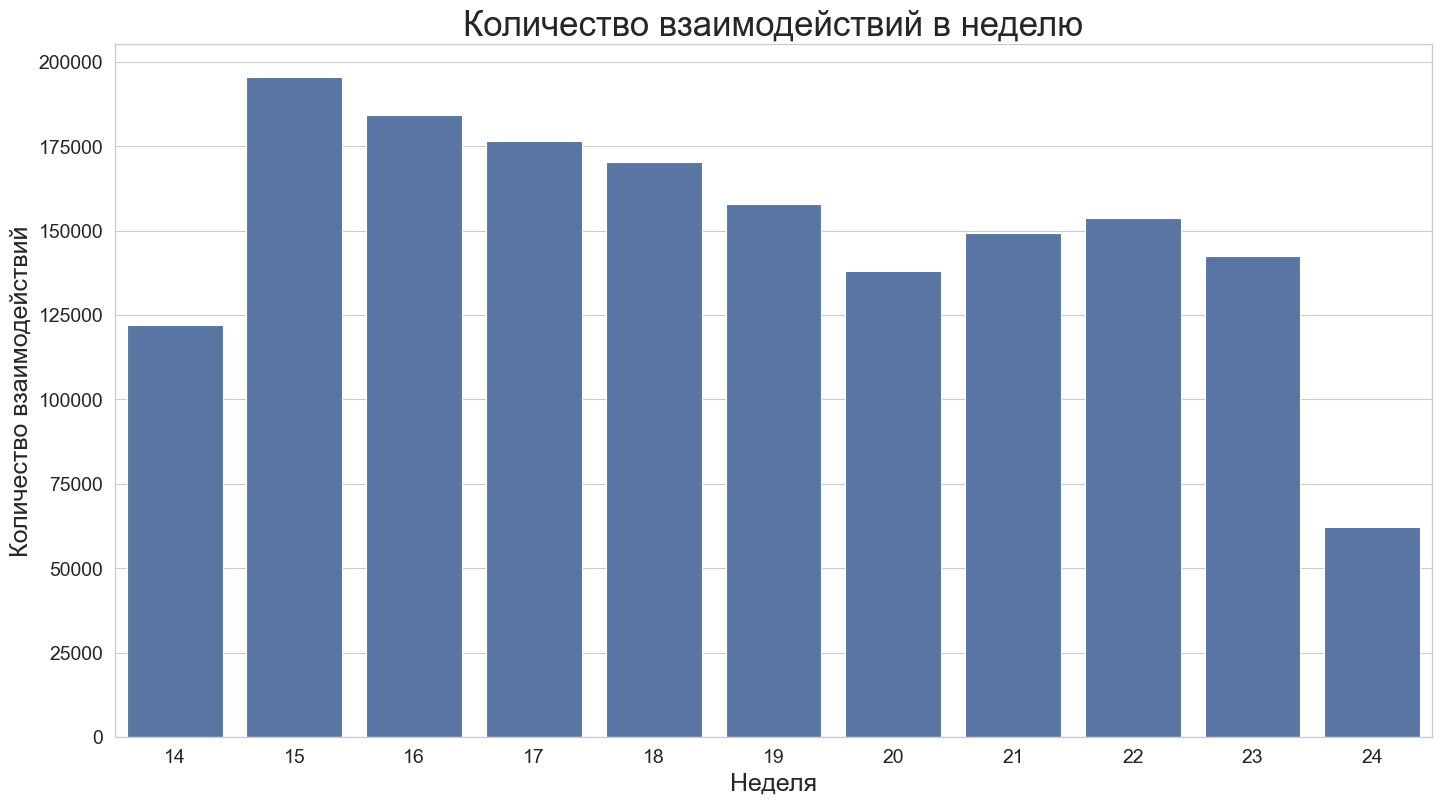

In [32]:
sns.set_theme(style='whitegrid', rc={'figure.figsize':(17, 9)})
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":25,"axes.labelsize":18,
                            "xtick.labelsize": 14, "ytick.labelsize": 14})

week = pd.DataFrame({'week': dataset.logs['week_number']})
week_progress = week.value_counts().reset_index(name='num_watches')

sns.barplot(data=week_progress, x='week', y='num_watches')
plt.title('Количество взаимодействий в неделю')
plt.ylabel('Количество взаимодействий')
plt.xlabel('Неделя')
plt.show()

Наше решение строится на учете времени просмотров фильмов юзерами и актуальности данных, поэтому нам нужно было первоначально учесть, что количество информации на каждую неделю у нас примерно равное и нет "проплешин", которые могут нам помешать.

Мы можем видеть на графике, что последняя неделя у нас в 2 раза меньше в сравнении с остальными, но при этом она содержит в себе самые актуальные данные. Поэтому для обучения catboost мы взяли 3 последних недели, чтобы оставить обучение на самых актуальных данных и не потерять их количество.

---

[Text(0.5, 0, 'К-во просмотренных фильмов'),
 Text(0, 0.5, 'К-во пользователей'),
 Text(0.5, 1.0, 'Сколько пользователей посмотрели хотя бы n фильмов')]

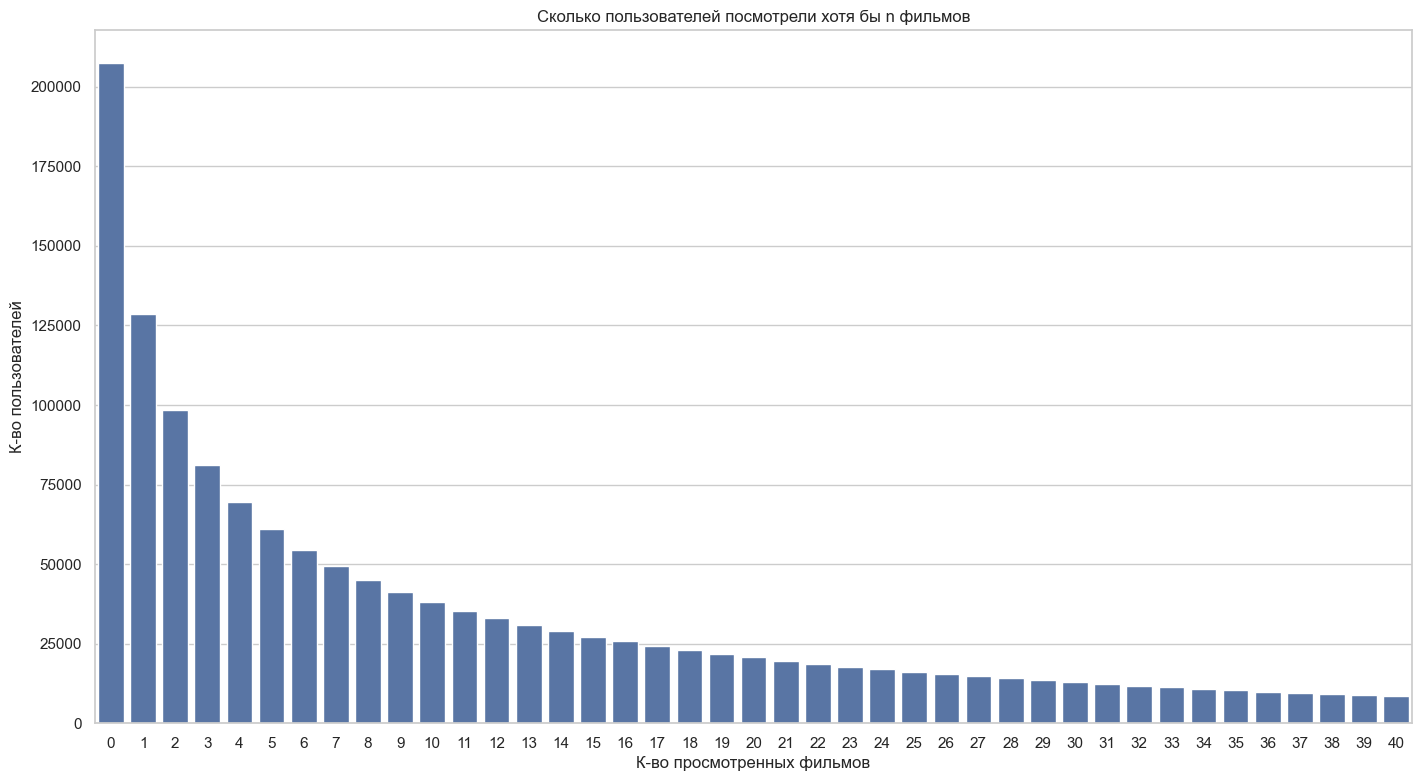

In [26]:
count_users_by_views = pd.DataFrame({'x': list(range(41)), 'y':0})
for i in range(41):
    count_users_by_views.loc[i, 'y'] = len(dataset.logs.groupby('user_id').filter(lambda x: len(x) > i)['user_id'].unique())

sns.set_theme(style='whitegrid', rc={'figure.figsize':(17, 9)})
ax = sns.barplot(data=count_users_by_views, x='x', y='y')
ax.set (xlabel='К-во просмотренных фильмов',
ylabel='К-во пользователей',
title='Сколько пользователей посмотрели хотя бы n фильмов')

График показывает, насколько сильно у нас происходит дизбаланс между количеством пользователей у которых мало просмотренных фильмов и много. Это означает, что большинство данных, с которыми мы работаем имеют малое количество истории, что сильно сказывается на точности предсказаний, так как модели не могут находить похожих по взаимодействиям пользователей.

---

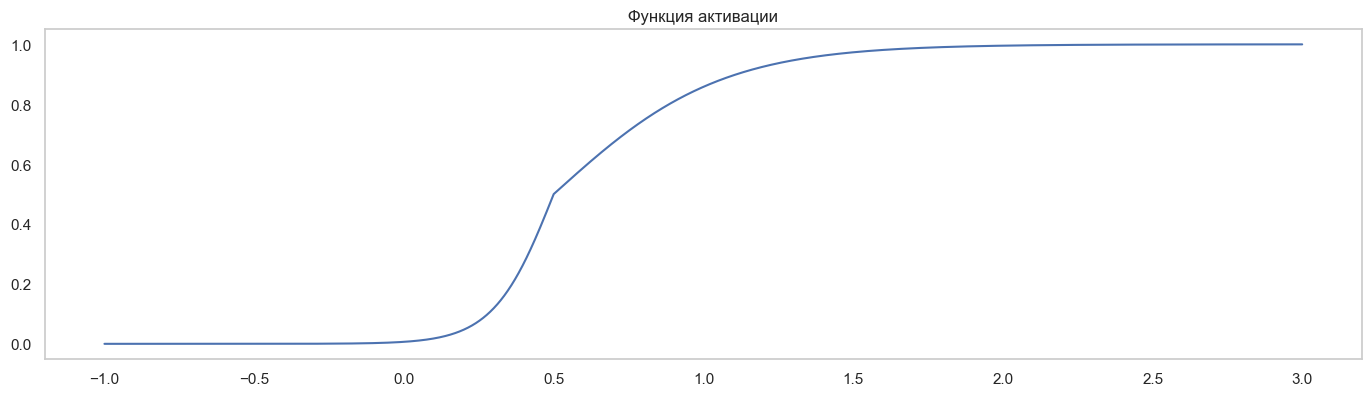

In [27]:
x_points = np.arange(-1, 3, 0.001)
y_points = [feature_creator.activation_function(x) for x in x_points]

fig, axes = plt.subplots()
axes.plot(x_points, y_points)

axes.grid()

axes.axis('scaled')
plt.title('Функция активации')
plt.show()

У нас отсуствует информация по оценке пользователем фильма, поэтому мы решили получить приблизительную оценку по проценту просмотра фильма пользователем. График "функции активации" отображает каким образом происходит распределение процента просмотра к нашей оценке. Полученная функция учитывает ряд информации, которую мы и хотели туда вложить:
- Учитывание нескольких просмотров. При просмотре нескольких раз фильма наша функция уходит в единицу.
- Занижение оценки при просмотре фильма менее половины.
- Завышения показателей при просмотре фильма более половины.

Таким образом, наша функция помогает примерно понять оценку пользователя в зависимоти от процента его просмотра.

---

<Axes: title={'center': 'К-во юзеров в зависимости от процента просмотра фильмов'}, ylabel='К-во юзеров'>

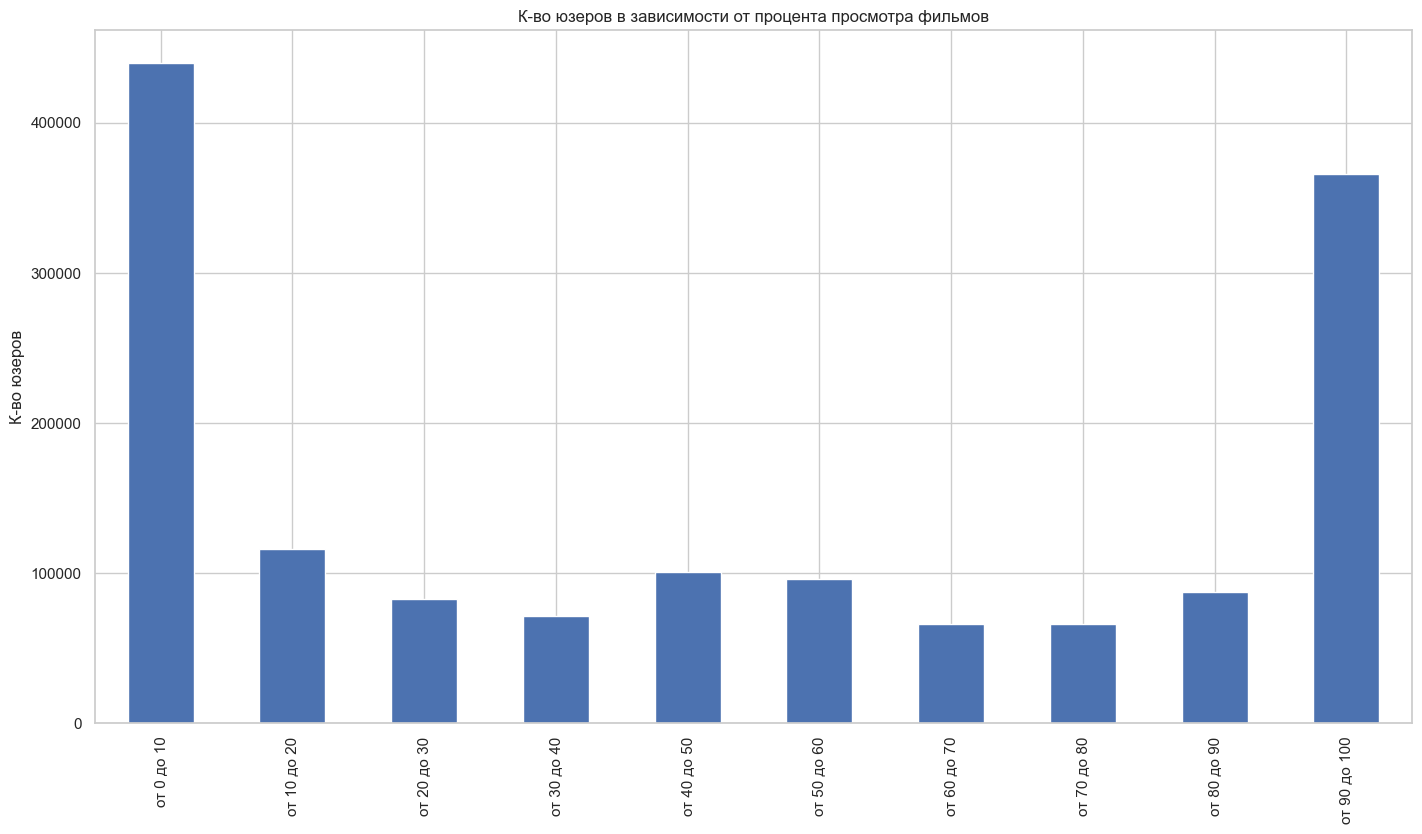

In [28]:
res = {}

cur_series = dataset.logs['percent_of_watch'] * 100
for interval in range(10, 101, 10):
    res[f'от {interval-10} до {interval}'] = len(cur_series[cur_series.between(interval - 10, interval, inclusive='both')])

pd.Series(res).plot(kind='bar', title='К-во юзеров в зависимости от процента просмотра фильмов', ylabel='К-во юзеров')

График отображающий количество юзеров в зависимости от процента просмотра фильмов. Мы видим дизбаланс по количеству людей, которые посмотрели от 0 до 10 процентов фильма. Если мы посмотрим на количество людей, которые посмотрели фильмы от 0 до 30 процентов, то увидим, что это количество занимает у нас более четверти всех записей с фильмами. В связке с дизбалансом по количеству просмотров у пользователей мы получаем большое количество данных, где был просмотрен 1 фильм и при этом даже не был просмотрен до конца или хотя бы на 30%. 

---

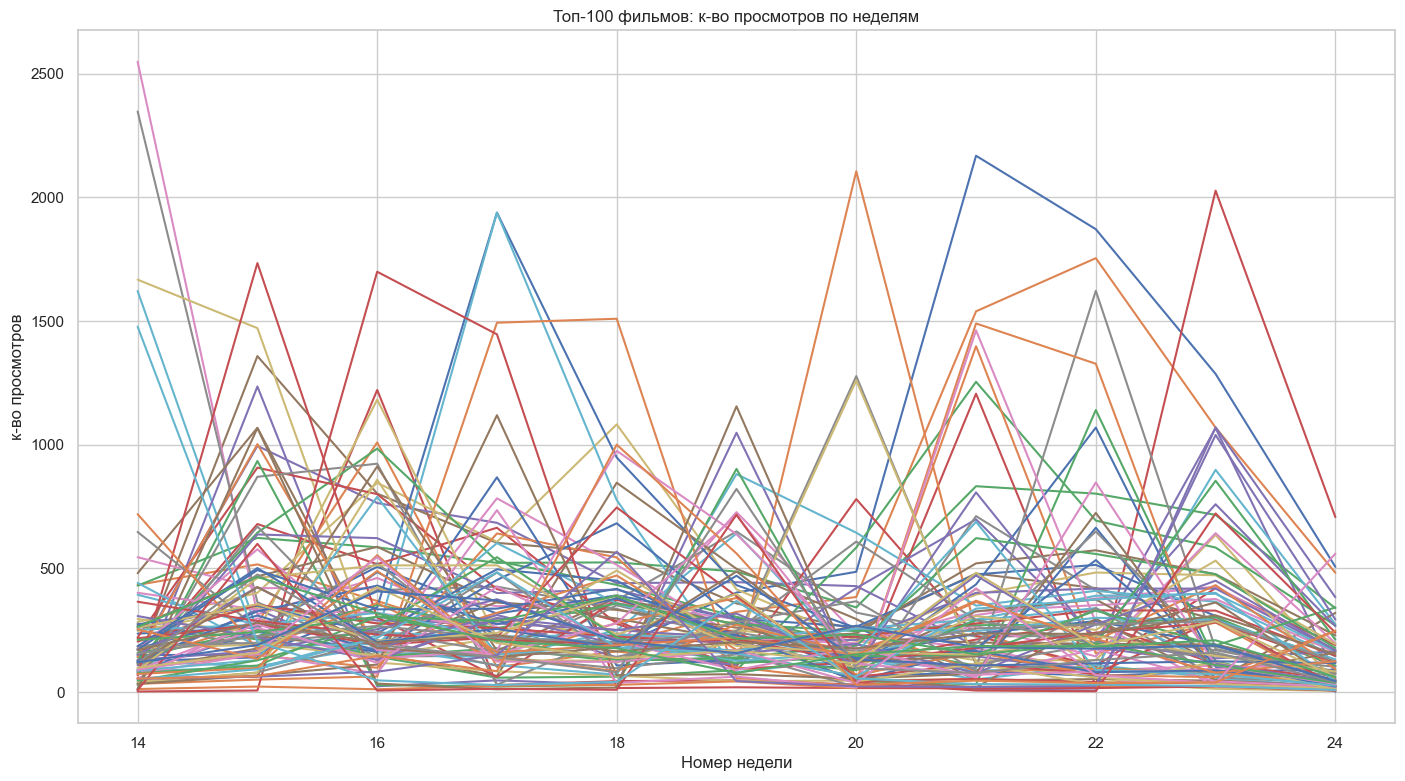

In [29]:
top100_movies = dataset.movies.sort_values('views', ascending=False)[:100]['id']
cur_df = dataset.logs[dataset.logs.movie_id.isin(top100_movies)].groupby(['movie_id', 'week_number']).agg(len)['user_id']

res = {}
for movie_id in top100_movies:
    if 14 in cur_df.loc[movie_id].index:
        cur_df.loc[movie_id].plot(kind='line', title='Топ-100 фильмов: к-во просмотров по неделям', xlabel='Номер недели', ylabel='к-во просмотров')

График отображает количество просмотров у топ 100 фильмов по неделям. Мы видим, что у нас часто присуствуют пики по количеству просмотров. Например, это может быть связано с выходом новой серии сериала или же резонасным событием с каким-то актером. Для того, чтобы учесть эту сезонность мы сделали фичи по линии тренда для фильмов и количеству просмотров за несколько дней. Так же этот график описывает, почему локальный coldstart имеет большую точность, нежели общий.

Локальный coldstart смотрит на самые популярные фильмы за промежуток времени.

---

100%|██████████| 19/19 [03:15<00:00, 10.29s/it]


<Axes: title={'center': 'Доля истинных кандидатов среди предсказанных'}, xlabel='К-во просмотренных фильмов у юзера', ylabel='Доля'>

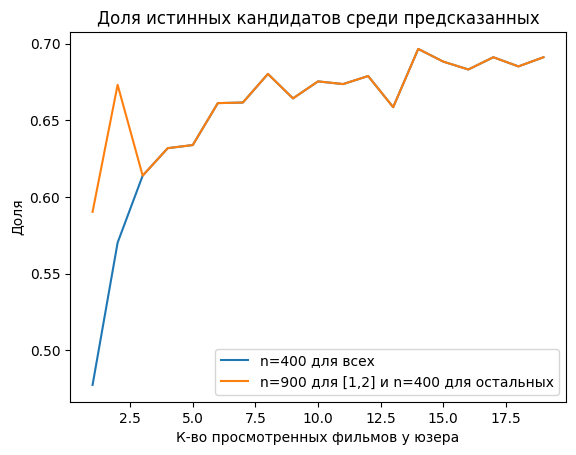

In [29]:
def predict_user(model, user_id, items, n=500):
    enum_users = np.zeros(len(items)).astype(int)
    enum_items = np.array(list(items)).astype(int)

    cur_sparse_matrix = sparse.csr_matrix(
        (np.ones(shape=(len(enum_users))), (enum_users, enum_items))
    )
    rec = model.recommend(user_id, cur_sparse_matrix, N=n, recalculate_user=False,
                     filter_already_liked_items=True)
    idx = range(len(rec[0]))
    idx = sorted(idx, key=lambda x: rec[1][x], reverse=True)
    return list(zip(rec[0][idx], rec[1][idx]))


first_pq_dict = {}
items = d1.sort_values(by="datetime", ascending=False).groupby('user_id')['movie_id'].agg(list)
ids = d1.user_id.unique()

for num_views in tqdm(range(1, 20)):
    local_ids = d1.groupby('user_id').filter(lambda x: len(x) == num_views).user_id.unique()
    local_d2 = d2[d2.user_id.isin(local_ids)]
    val_ids = local_d2.user_id.unique()
    correct_candidates_valid = local_d2.groupby('user_id')['movie_id'].agg(list)
    num_candidates = 900 if num_views in [1, 2] else 400

    p, q = 0, 0
    for user_id in val_ids:
        try:
            X1 = [item[0] for item in predict_user(old_pred_models.model_nn, user_id, items[user_id], num_candidates)]
            X2 = [item[0] for item in predict_user(old_pred_models.model_als, user_id, items[user_id], num_candidates)]
            p += len((set(X1) | set(X2)) & set(correct_candidates_valid[user_id]))
            q += len(set(correct_candidates_valid[user_id]))
        except Exception:
            continue
    first_pq_dict[num_views] = p/q

second_pq_dict = {}

for num_views in tqdm(range(1, 20)):
    local_ids = d1.groupby('user_id').filter(lambda x: len(x) == num_views).user_id.unique()
    local_d2 = d2[d2.user_id.isin(local_ids)]
    val_ids = local_d2.user_id.unique()
    correct_candidates_valid = local_d2.groupby('user_id')['movie_id'].agg(list)
    num_candidates = 400

    p, q = 0, 0
    for user_id in val_ids:
        try:
            X1 = [item[0] for item in predict_user(old_pred_models.model_nn, user_id, items[user_id], num_candidates)]
            X2 = [item[0] for item in predict_user(old_pred_models.model_als, user_id, items[user_id], num_candidates)]
            p += len((set(X1) | set(X2)) & set(correct_candidates_valid[user_id]))
            q += len(set(correct_candidates_valid[user_id]))
        except Exception:
            continue
    second_pq_dict[num_views] = p/q

pd.DataFrame({'n=400 для всех': second_pq_dict.values(), 'n=900 для [1,2] и n=400 для остальных': first_pq_dict.values(),
'К-во просмотренных фильмов у юзера': first_pq_dict.keys()}).plot(kind='line',
title='Доля истинных кандидатов среди предсказанных', ylabel='Доля', legend="second",
x='К-во просмотренных фильмов у юзера')




По графикам выше, мы можем увидеть, что в данных у нас много людей, у которых 1-2 просмотра, по которым нам сложно угадывать долю истинных просмотров, поэтому мы постарались увеличить эту долю повысив количество генерируемых кандидатов предмоделями. По графикам видно, что нам удается это сделать и уменьшить дисперсию за счет этого, хоть и видна положительная корреляция с количеством просмотренных фильмов у пользователей.

Ручная настройка количества кандидатов очень затруднительна в большинстве ситуаций, поэтому есть идеи реализации активного подбора количества кандидатов для каждого кол-ва просмотренных фильмов, что мы собираемся реализовать в будущем.

# Экспериментальные данные

Не сработавшие фичи:
* пересечение любимых жанров юзера и жанров этого фильма
* сколько юзер смотрел фильмы такого же жанра
* сколько раз раньше юзер смотрел фильмы этого режиссёра
* любимые жанры, режиссёры и актёры юзера
* есть ли его любимый жанр в этом фильме
* сколько в среднем юзер смотрит фильмы
* сколько в среднем жанров у просматриваемых юзером фильмов
* среднее количество просмотров у режиссёра
* сколько раз юзер смотрел фильмы этой страны
* эмбеддинги описания фильма из дообученного BERT (Bidirectional Encoder Representations from Transformers)
* фичи из CoOccurence Recommender
* id фильмов, похожих на последний и предпоследний просмотренный фильм (как текстовая фича)
* сравнение названия фильма с последним просмотренным по токенам (с помощью либы FuzzyWuzzy)
* совпадает ли в текущем и последнем фильме хотя бы один из режиссеров
* отношение количества людей в пересечении персонала текущего фильма и последнего просмотренного к количеству людей в их объединении
* история просмотренных фильмов (список id фильмов) как текстовая фича
* просмартриваемость фильмов юзером в каждый отдельный день недели

Что ещё не сработало:
* LightFM, как в качестве предмодели для получения кандидатов, так и как часть ансамбля с катбустом
* TF-IDF Reccomender
* Остальные модели из библиотеки implicit (лучше всего после подбора гипермараметров сработали BM25 и ALS)
* Использование item similarity для получения дополнительных фильмов-кандидатов
* CoOccurence Recommender немного улучшил точность, но требовал слишком много оперативной памяти, поэтому отказались от него
* Использование explicit моделей при использовании функции активации в качестве оценки пользователей
* Использование функции активации при построении sparce_matrix 